In [1]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [2]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import scanpy, networkx, scprep, magic, phate, scipy, DiffusionEMD, pygsp, torch, sklearn
import rpy2, rpy2.situation, anndata2ri
from localization import * #Wavelet module

In [3]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

/Users/ferran/PhD/yaleCollab


In this notebook we will compute a wavelet dictionary on the NicheNet KG and KGE
using the 4 fibroblast cocults.

Rough outline will be to load individual Seurat->AnnData objects, check viz and metadata,
concat them all (keeping common genes). Also concat the metadata dataframes.

* Use the concat logcounts for KG matching and wavelet projection
* Metadata will be useful to review final embedding (see if we have any major batch efects)

# Data ingestion

## Load scRNAseq data

We will have to use rpy to import the seurat object with the data. From there we already have code (from RNA Velo NBs) to extract metadata. Need to extract count matrices.

In [4]:
for i in rpy2.situation.iter_info(): # Print Rpy2 info
    print(i)

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Looking for R's HOME:
    Environment variable R_HOME: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Calling `R RHOME`: /Users/ferran/miniconda3/envs/collabLite/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/lib/R/library/stats/libs/:/usr/local/lib/R/library/stats/libs/
R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/Users/ferran/miniconda3/envs/collabLite/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/Users/ferran/miniconda3/envs/collabLite/lib', '/Users/ferran/miniconda3/envs/collabLite/lib/R/lib', '/Users/ferran/miniconda3/envs/collabLite/lib']
  extra_compile_args:
  []
  extra_lin

In [5]:
anndata2ri.activate() #This HAS TO be run b4 loading the rpy2 extension
%load_ext rpy2.ipython


In [6]:
%%R -i data_dir
library(tidyverse)
library(Seurat)

paste0(data_dir)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

R[write to console]: Attaching SeuratObject

R[write to console]: Attaching sp



[1] "/Users/ferran/PhD/yaleCollab/data"


In [7]:
%%R -o d_fibWT,d_fibA,d_fibAK,d_fibAKP,dPHATEcoord_WT,dPHATEcoord_A,dPHATEcoord_AK,dPHATEcoord_AKP

d_fibWT = readRDS(paste0(data_dir,"/Omics/","d_fibWT.rds"))
d_fibWT@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibWT)
#Export PHATE coordinates
dPHATEcoord_WT = as.data.frame(Embeddings(d_fibWT, reduction = "phate"))
#Convert seurat object to anndata
d_fibWT = as.SingleCellExperiment(d_fibWT)

d_fibA = readRDS(paste0(data_dir,"/Omics/","d_fibA.rds"))
d_fibA@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibA)
#Export PHATE coordinates
dPHATEcoord_A = as.data.frame(Embeddings(d_fibA, reduction = "phate"))
#Convert seurat object to anndata
d_fibA = as.SingleCellExperiment(d_fibA)

d_fibAK = readRDS(paste0(data_dir,"/Omics/","d_fibAK.rds"))
d_fibAK@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibAK)
#Export PHATE coordinates
dPHATEcoord_AK = as.data.frame(Embeddings(d_fibAK, reduction = "phate"))
#Convert seurat object to anndata
d_fibAK = as.SingleCellExperiment(d_fibAK)

d_fibAKP = readRDS(paste0(data_dir,"/Omics/","d_fibAKP.rds"))
d_fibAKP@active.assay <- "RNA" #Ensure RNA is default assay
print(d_fibAKP)
#Export PHATE coordinates
dPHATEcoord_AKP = as.data.frame(Embeddings(d_fibAKP, reduction = "phate"))
#Convert seurat object to anndata
d_fibAKP = as.SingleCellExperiment(d_fibAKP)


An object of class Seurat 
40940 features across 3698 samples within 2 assays 
Active assay: RNA (20867 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate
An object of class Seurat 
40964 features across 3646 samples within 2 assays 
Active assay: RNA (20923 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate
An object of class Seurat 
39062 features across 3391 samples within 2 assays 
Active assay: RNA (19919 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate
An object of class Seurat 
40650 features across 3811 samples within 2 assays 
Active assay: RNA (20786 features, 10000 variable features)
 1 other assay present: SCT
 3 dimensional reductions calculated: pca, umap, phate


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [8]:
list_RnaSeq = [d_fibWT,d_fibA,d_fibAK,d_fibAKP]
list_PHATEcoord = [dPHATEcoord_WT,dPHATEcoord_A,dPHATEcoord_AK,dPHATEcoord_AKP]

del d_fibWT,d_fibA,d_fibAK,d_fibAKP,dPHATEcoord_WT,dPHATEcoord_A,dPHATEcoord_AK,dPHATEcoord_AKP

In [9]:
for i in range(len(list_RnaSeq)):
    print(i)
    print(list_RnaSeq[i])
    print(list_PHATEcoord[i])

0
AnnData object with n_obs × n_vars = 3698 × 20867
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito_content', 'rfp_content', 'gfp_content', 'nCount_SCT', 'nFeature_SCT', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CCDiff', 'SCT_snn_res.0.6', 'seurat_clusters', 'curatedCLUST', 'old.clust', 'finalPOPS', 'ident'
    layers: 'logcounts'
                         PHATE_1   PHATE_2
WT__AAACCCACAGCTTCCT-1 -0.018518 -0.001424
WT__AAACCCAGTTCGAGCC-1 -0.019244 -0.003914
WT__AAACGAAAGAAGGATG-1 -0.020449 -0.003372
WT__AAACGAAAGGAAAGGT-1  0.031038  0.002025
WT__AAACGAAAGTTAACGA-1  0.026724 -0.003324
...                          ...       ...
WT__TTTGGTTTCATTCTTG-1  0.016370  0.001419
WT__TTTGGTTTCCGTAGTA-1 -0.018737 -0.003385
WT__TTTGTTGTCGCTTGAA-1  0.030721  0.000984
WT__TTTGTTGTCTGAATCG-1 -0.008438  0.016301
WT__TTTGTTGTCTGGGTCG-1  0.029887 -0.004444

[3698 rows x 2 columns]
1
AnnData object with n_obs × n_vars = 3646 × 20923
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'mito

In [10]:
list_RnaSeq[1].obs["orig.ident"][0]


'cocultAFib'

View Object and metadata

AxisArrays with keys: 
Before filtering the object we have 20867 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


After filtering genes expressed in fewer than 4 cells we have 16034
AxisArrays with keys: 
Before filtering the object we have 20923 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


After filtering genes expressed in fewer than 4 cells we have 16671
AxisArrays with keys: 
Before filtering the object we have 19919 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


After filtering genes expressed in fewer than 4 cells we have 15831
AxisArrays with keys: 
Before filtering the object we have 20786 genes


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


After filtering genes expressed in fewer than 4 cells we have 16965


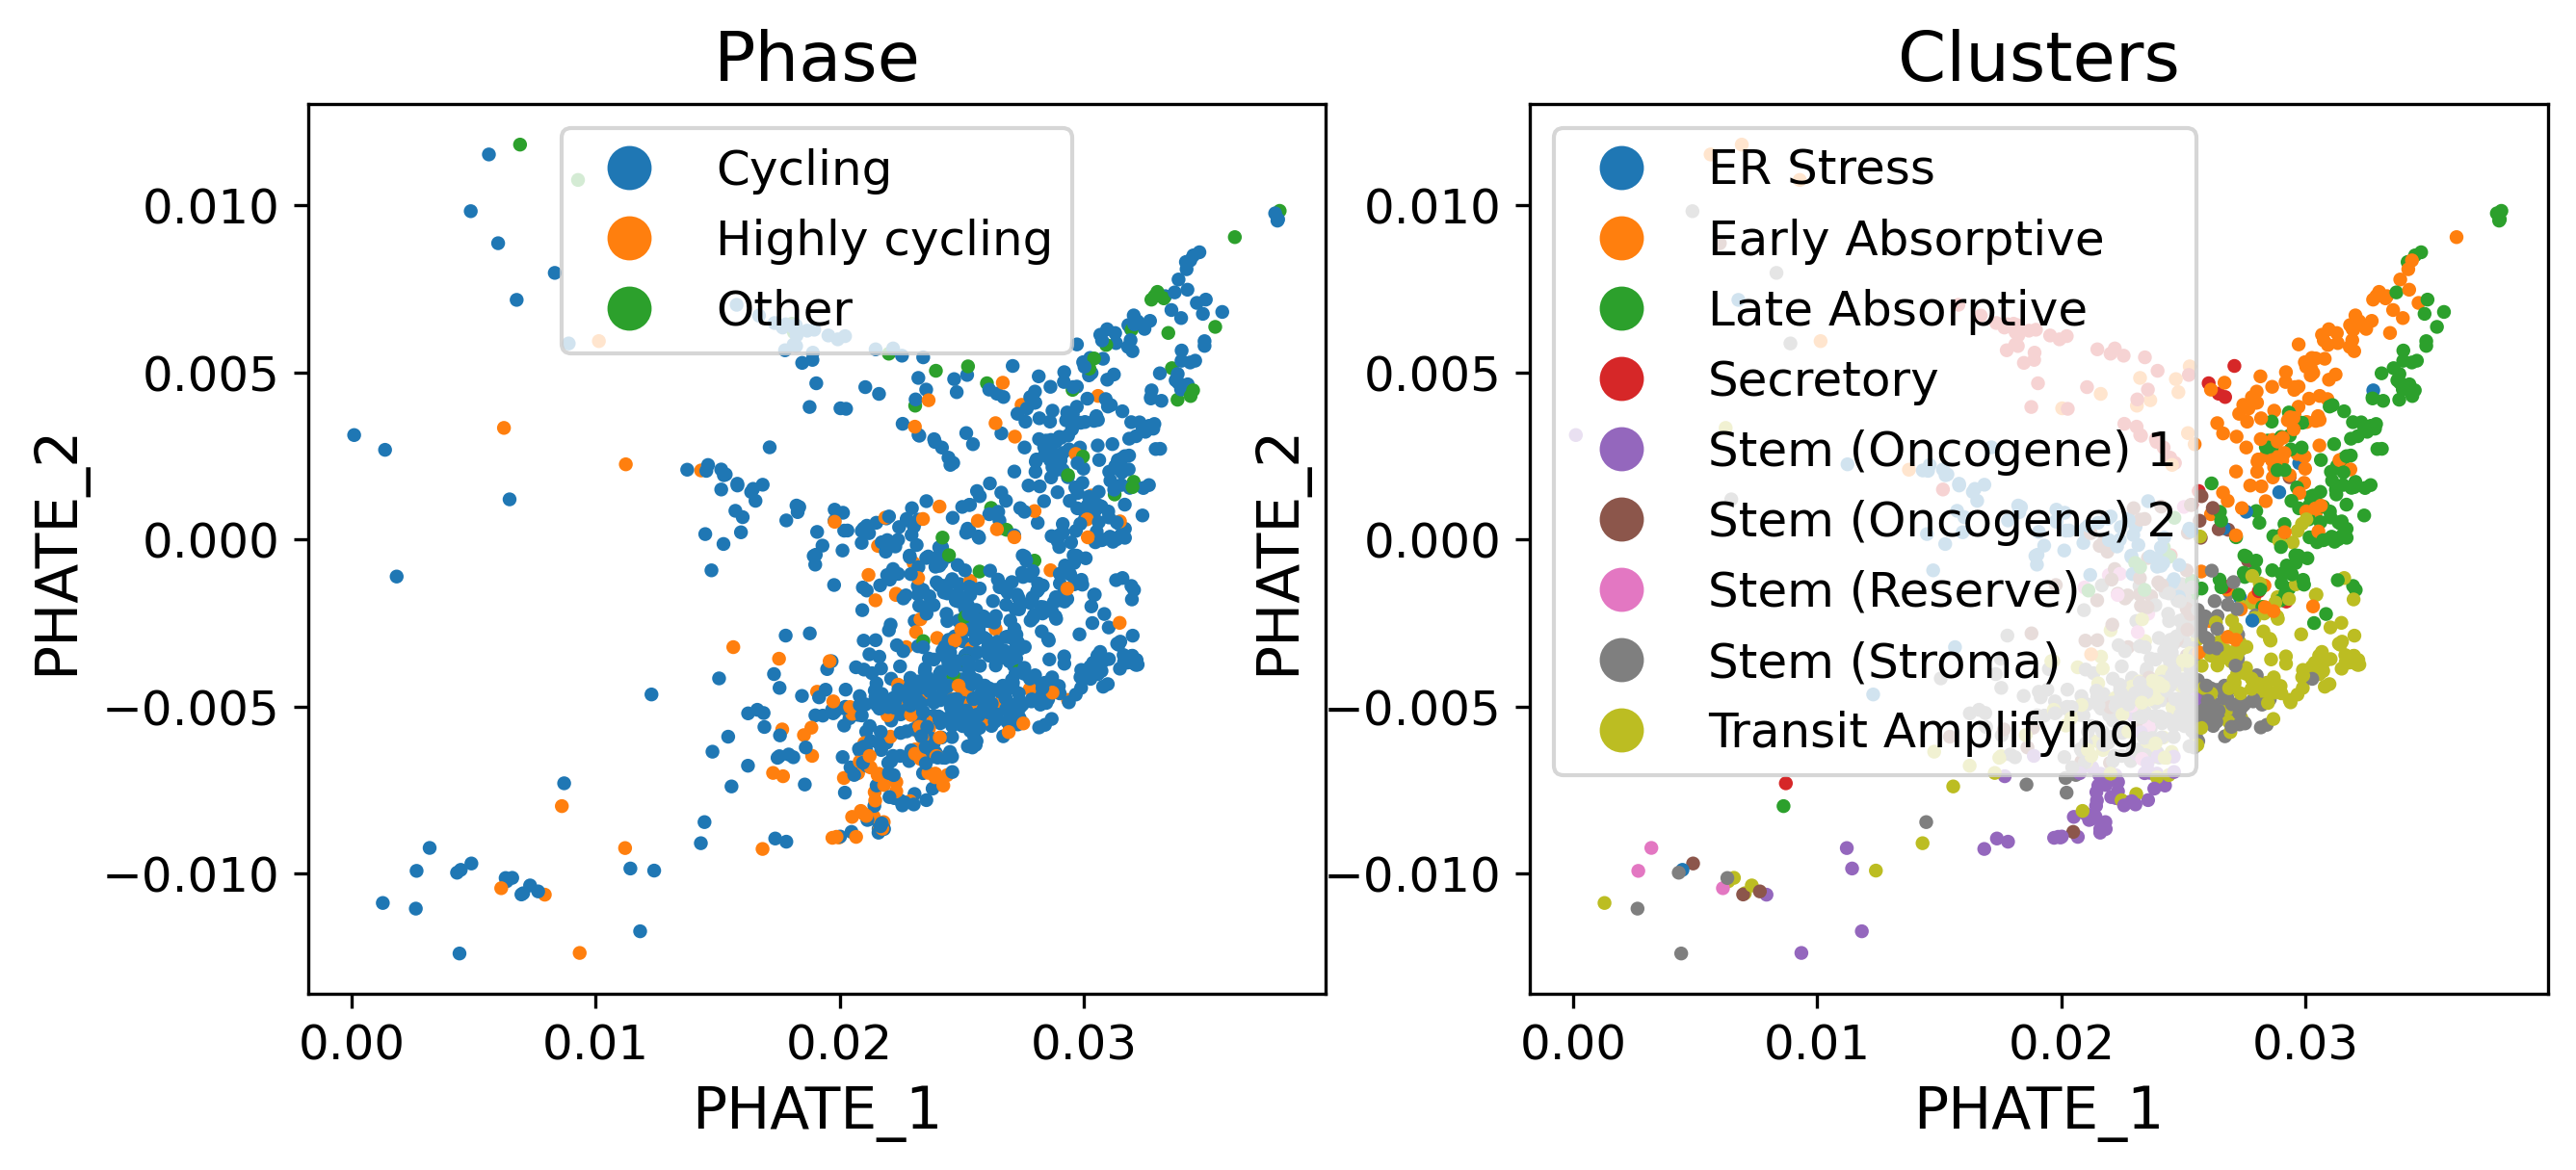

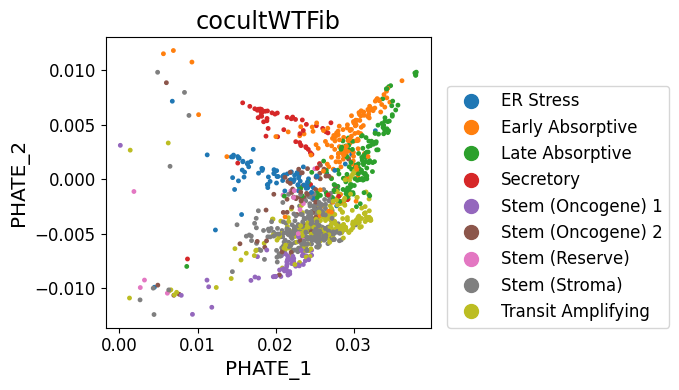

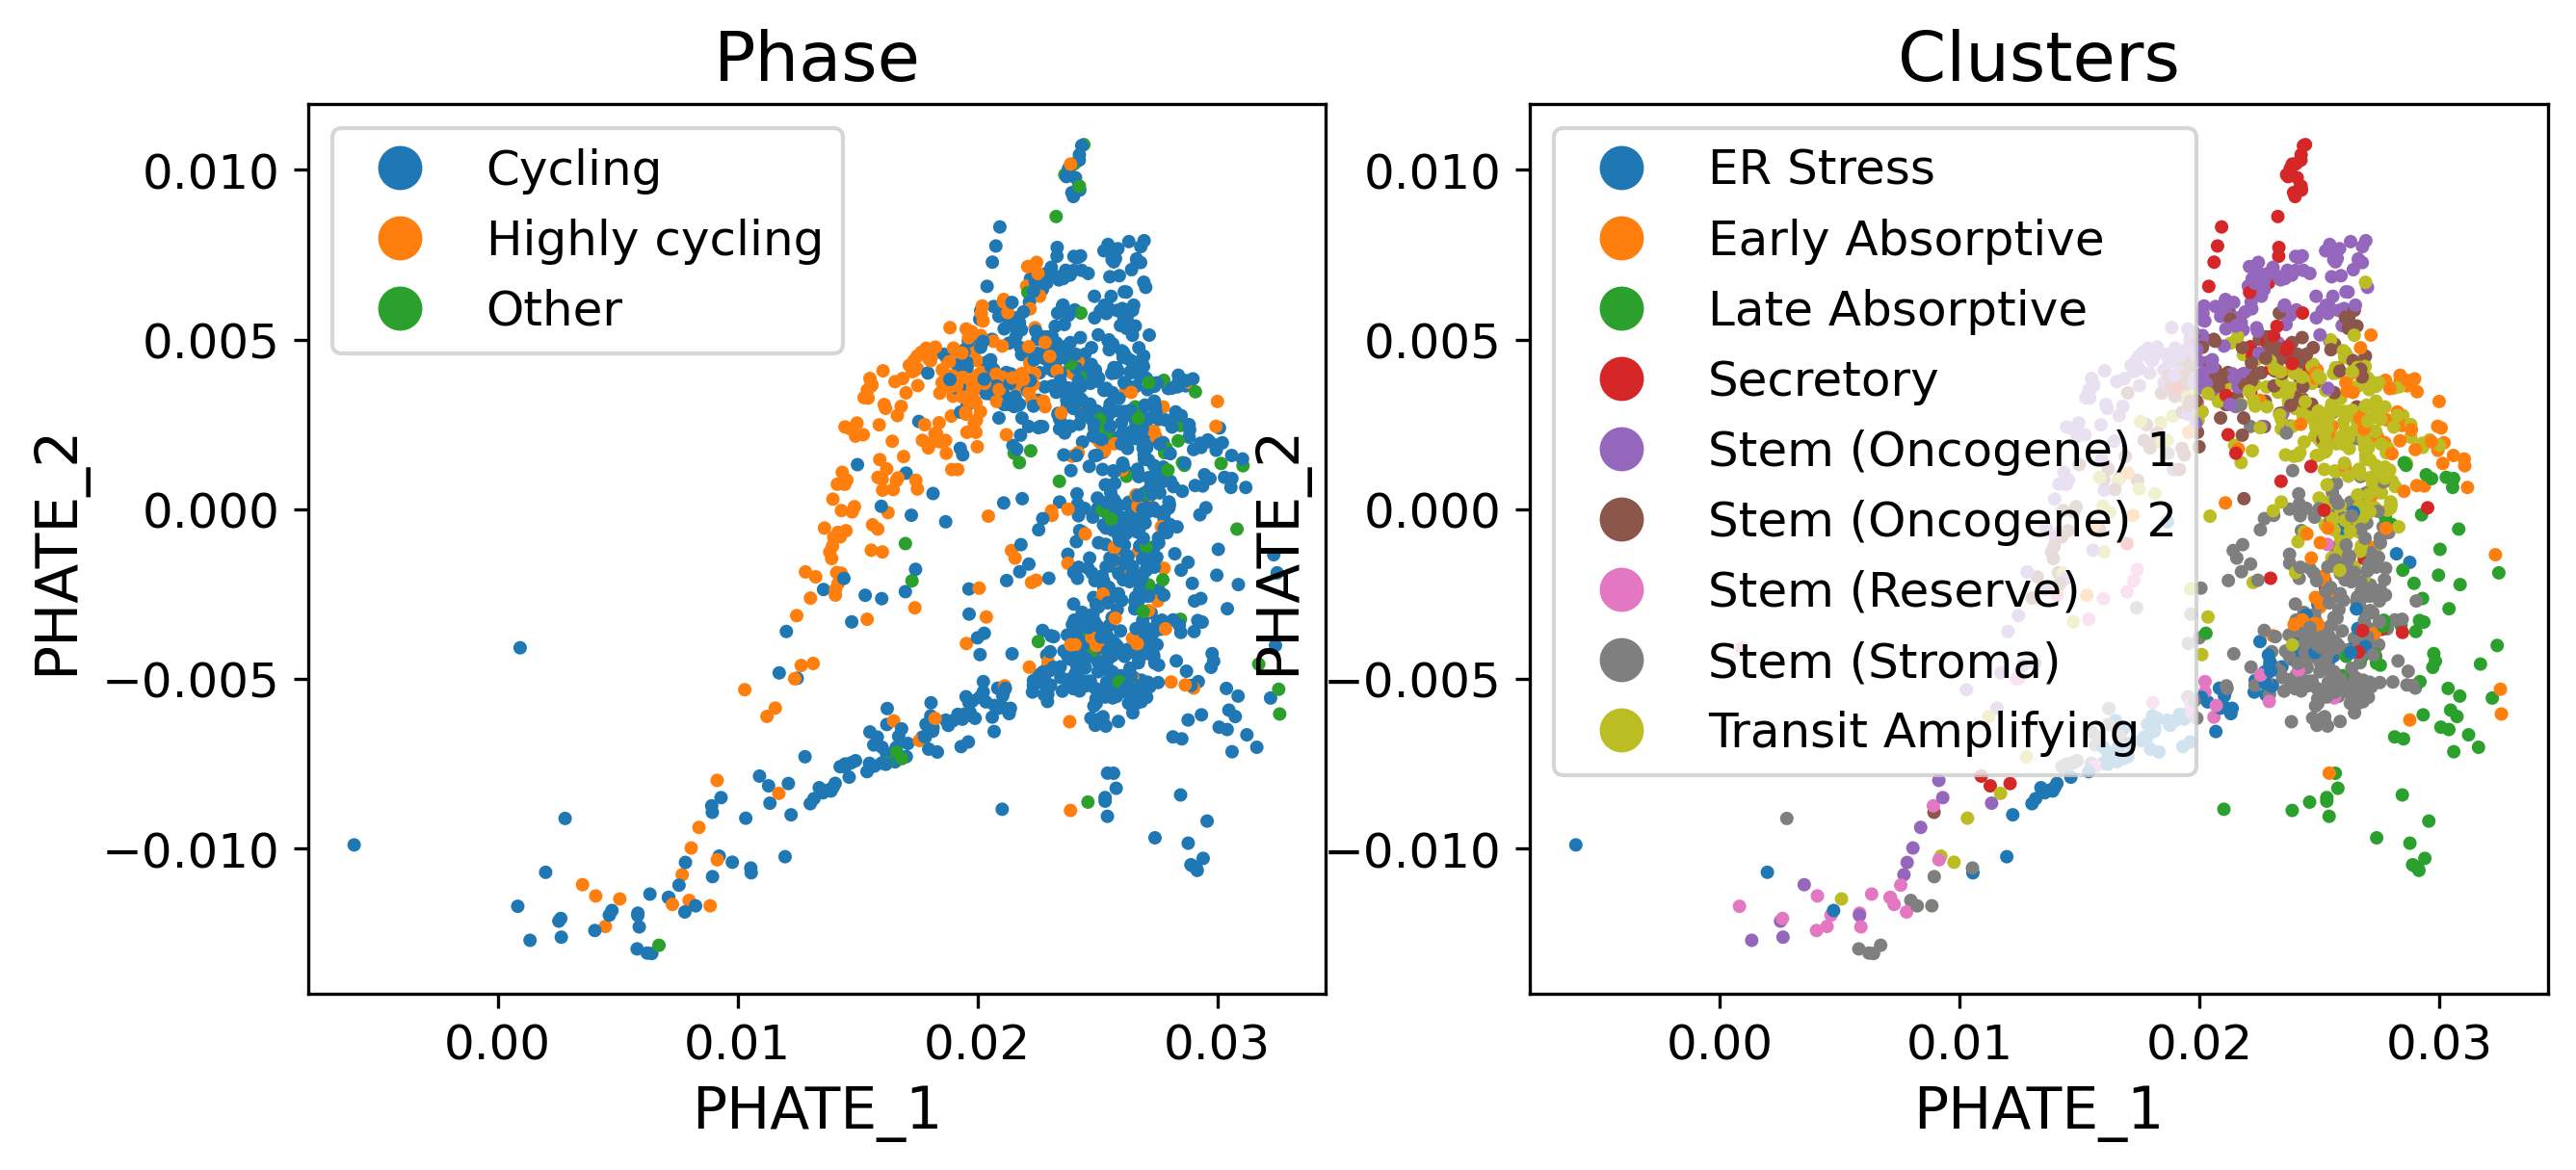

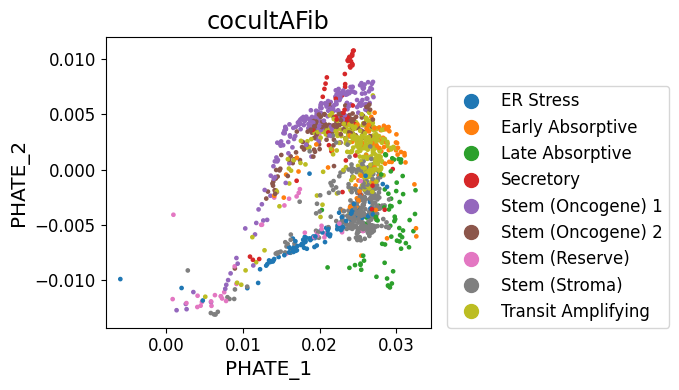

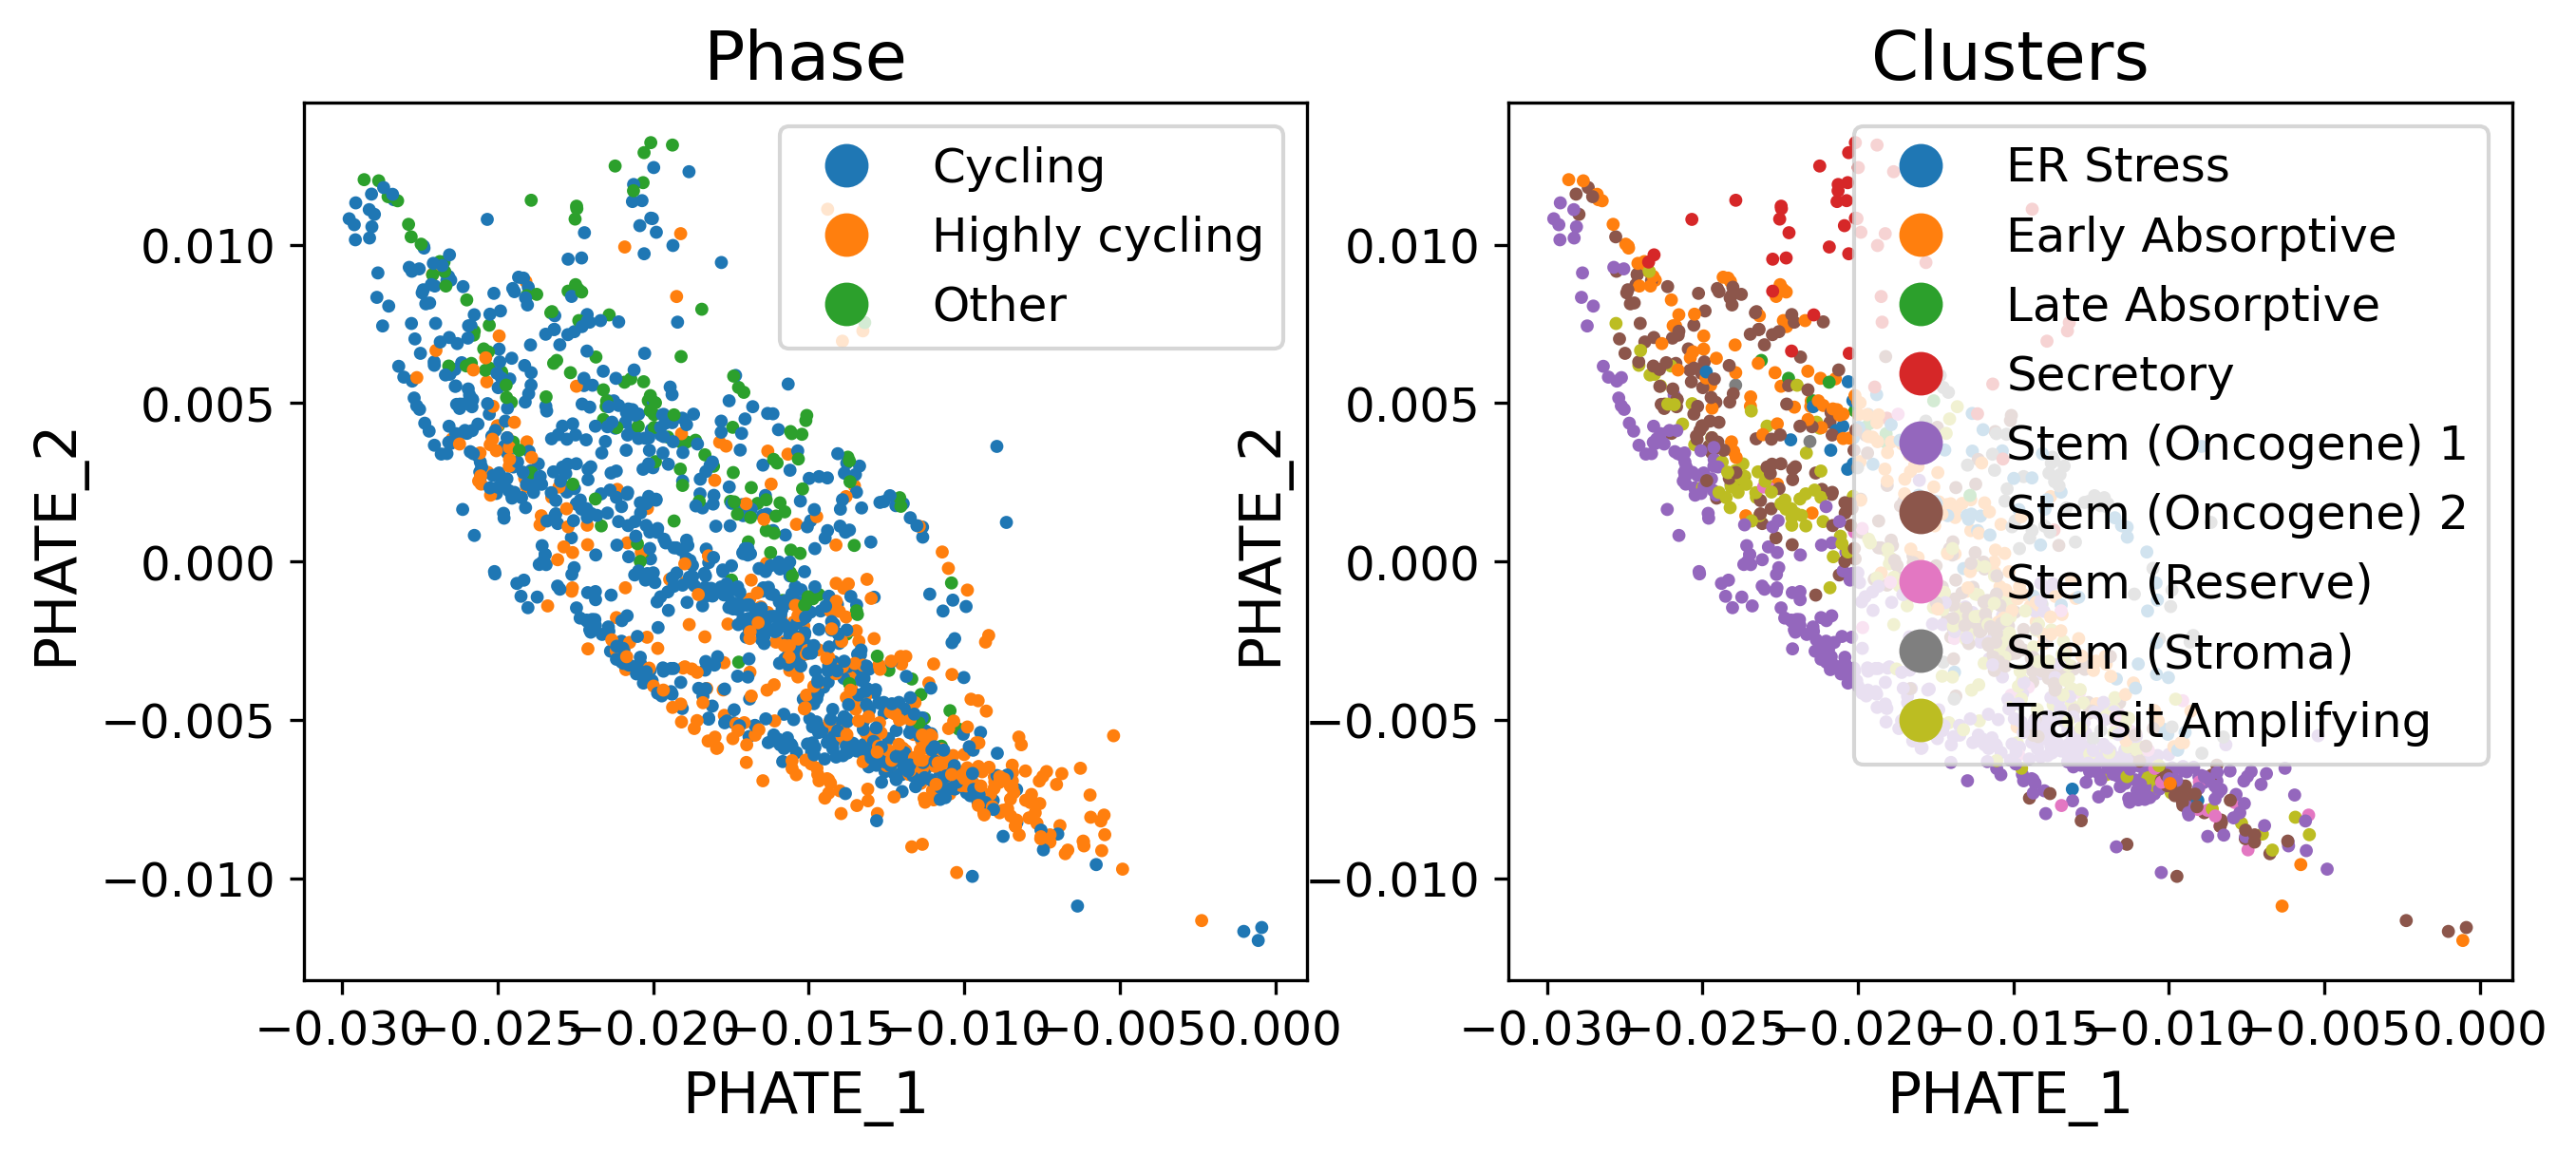

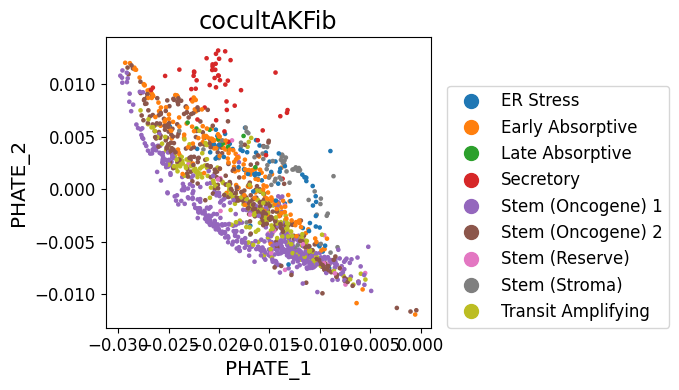

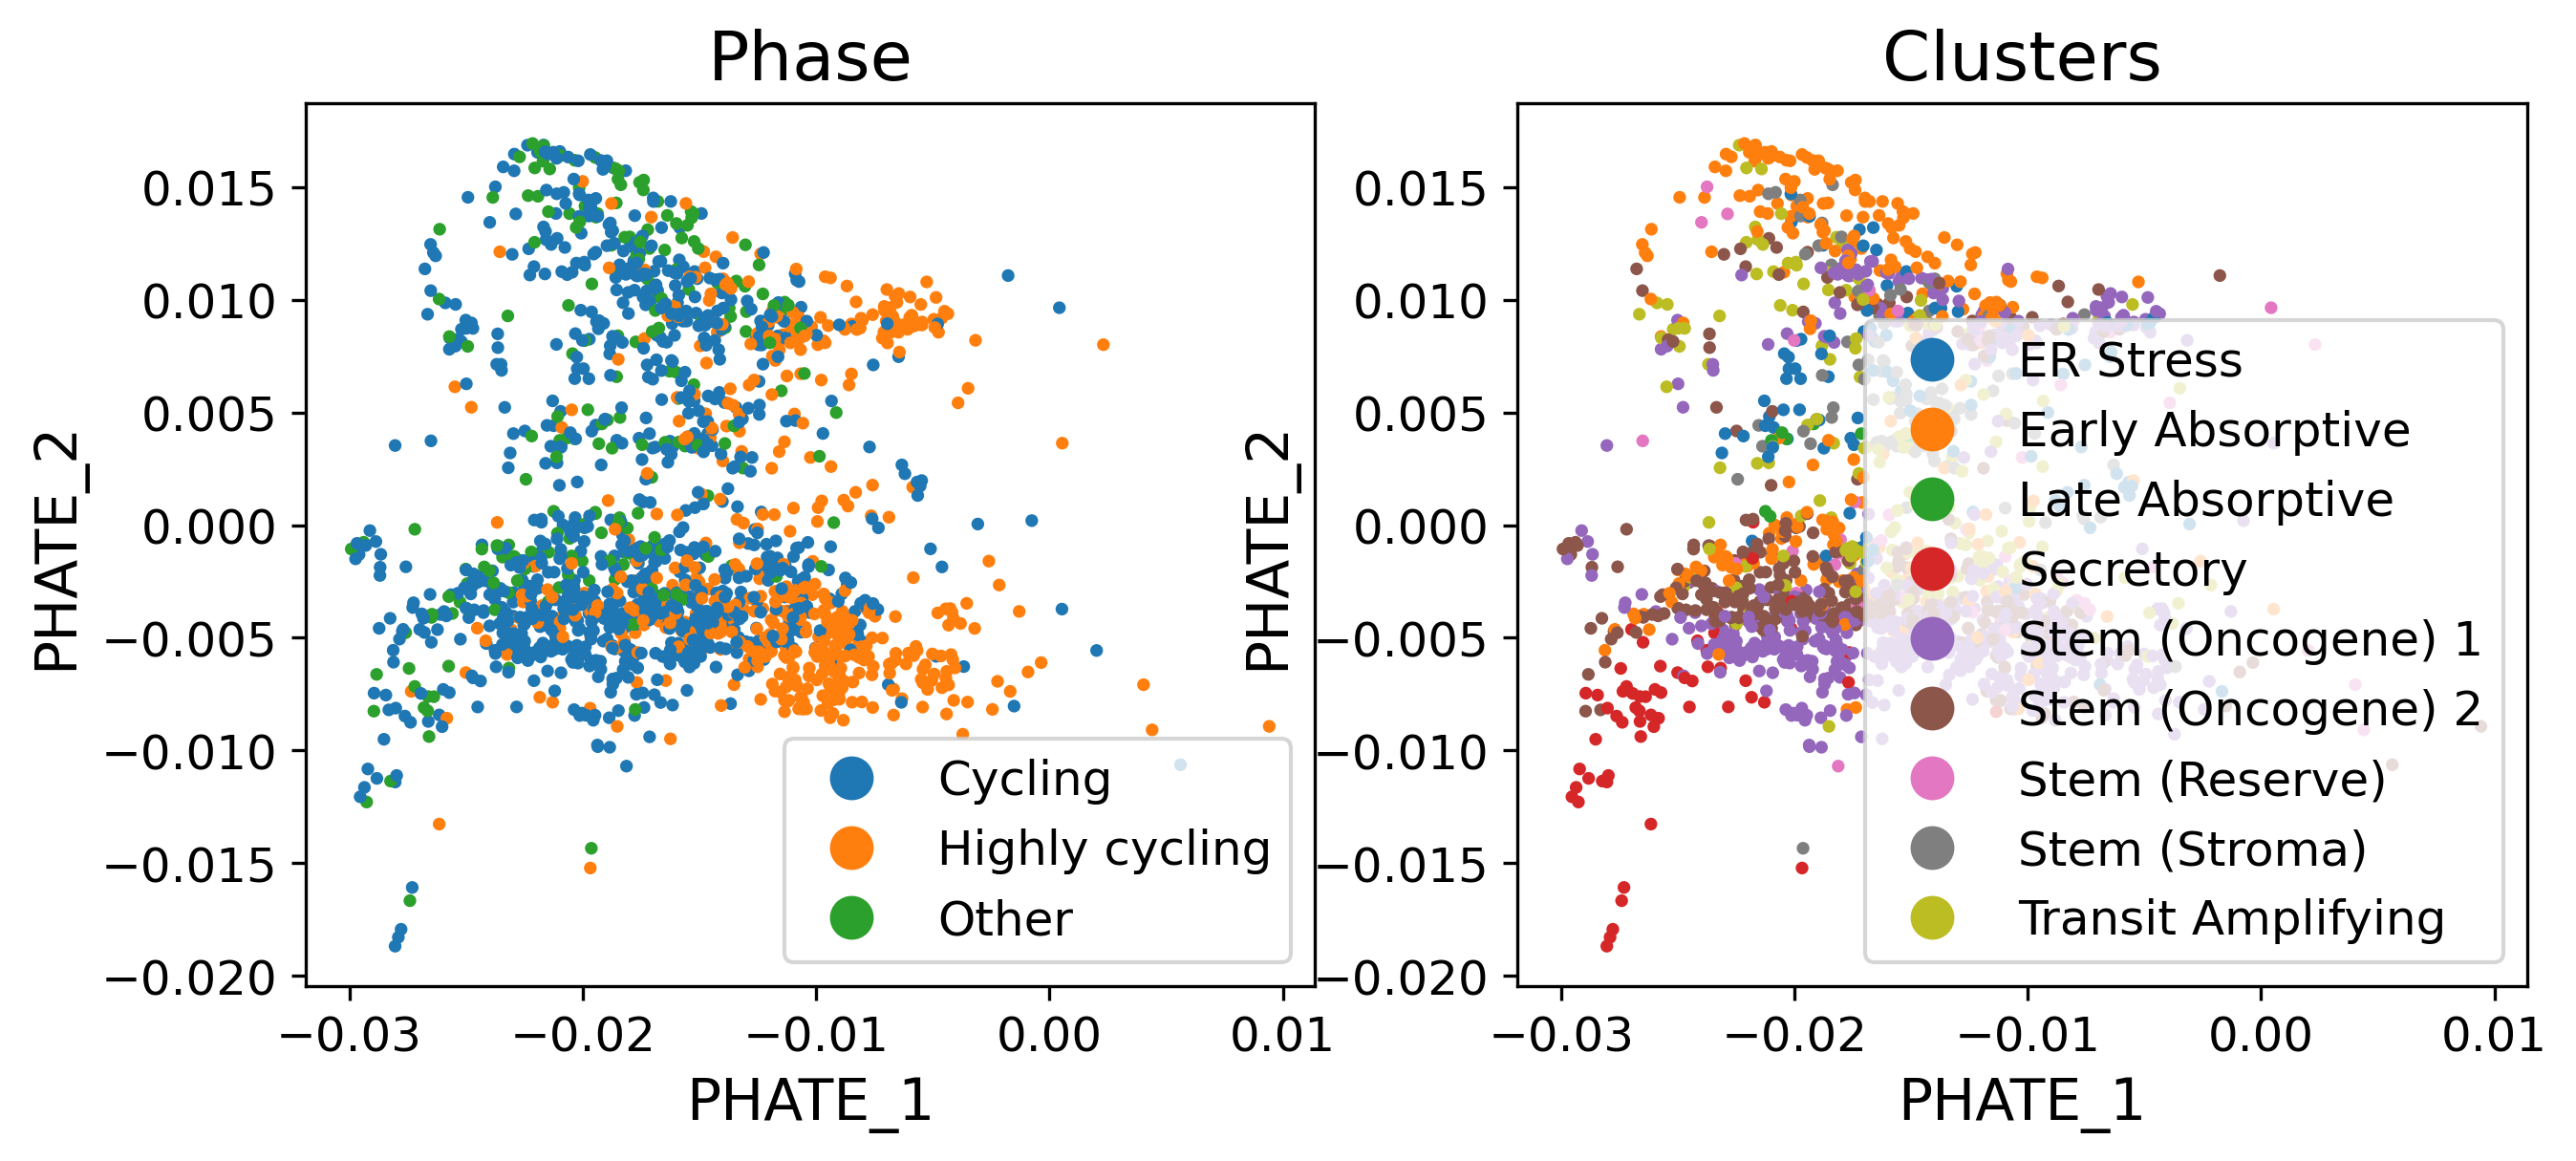

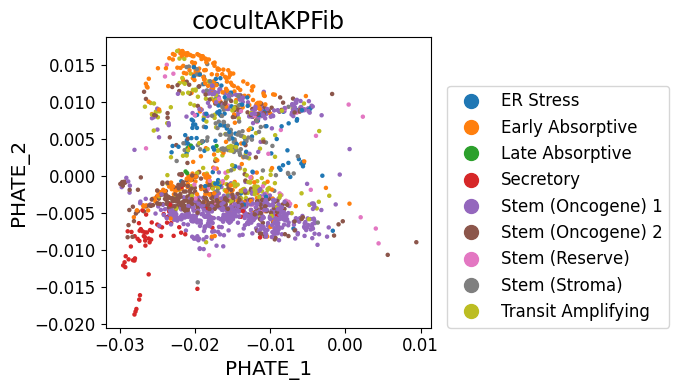

In [11]:
for i in range(len(list_RnaSeq)):
    print(list_RnaSeq[i].obsm)#No DimRed were ported over
    #Add phate dims and view
    list_RnaSeq[i].obsm["X_PHATE"] = list_PHATEcoord[i]

    list_RnaSeq[i] = list_RnaSeq[i][list_RnaSeq[i].obs["finalPOPS"] != "fibroblast"]

    fig, ax = plt.subplots(1,2, figsize=(10,4), dpi=300); ax=ax.flatten()
    scprep.plot.scatter2d(list_RnaSeq[i].obsm["X_PHATE"], c=list_RnaSeq[i].obs.Phase, figsize=(4.8,3),
        title=f"Phase", ax=ax[0])
    scprep.plot.scatter2d(list_RnaSeq[i].obsm["X_PHATE"], c=list_RnaSeq[i].obs.finalPOPS, figsize=(4.8,3),
        title=f"Clusters", ax=ax[1])

    scprep.plot.scatter2d(
        list_RnaSeq[i].obsm["X_PHATE"], 
        c=list_RnaSeq[i].obs.finalPOPS, 
        title=list_RnaSeq[i].obs["orig.ident"][0], 
        legend_loc=(1.05, 0), shuffle=True,
        figsize=(7,4), dpi=480)

    print(f"Before filtering the object we have {len(list_RnaSeq[i].var_names)} genes")
    scanpy.pp.filter_genes(list_RnaSeq[i], min_cells=4, inplace=True)
    print(f"After filtering genes expressed in fewer than 4 cells we have {len(list_RnaSeq[i].var_names)}")


In [12]:
#Generate concatenated logcount and MD dataframes
dRnaSeq = pd.concat([
    list_RnaSeq[0].to_df(layer="logcounts"),
    list_RnaSeq[1].to_df(layer="logcounts"),
    list_RnaSeq[2].to_df(layer="logcounts"),
    list_RnaSeq[3].to_df(layer="logcounts")
    ])
dRnaSeq

Gm6123    Mrpl15    Lypla1  Gm37988     Tcea1  Rgs20  \
WT__AAACGAAAGGAAAGGT-1      0.0  0.000000  0.000000      0.0  0.000000    0.0   
WT__AAACGAAAGTTAACGA-1      0.0  1.006380  0.000000      0.0  0.402734    0.0   
WT__AAAGAACAGCAGCGAT-1      0.0  1.044176  0.478520      0.0  0.000000    0.0   
WT__AAAGAACTCTACTGAG-1      0.0  0.556447  0.316438      0.0  0.749856    0.0   
WT__AAAGTCCAGTAACGTA-1      0.0  0.847374  0.287715      0.0  0.287715    0.0   
...                         ...       ...       ...      ...       ...    ...   
AKP__TTTGACTTCCTTCAGC-1     0.0  1.137571  0.353355      NaN  0.613927    0.0   
AKP__TTTGATCGTACGCTAT-1     0.0  1.369070  0.281973      NaN  1.083316    0.0   
AKP__TTTGGTTTCTCACCCA-1     0.0  1.180167  0.447074      NaN  0.000000    0.0   
AKP__TTTGTTGGTCGCATTA-1     0.0  1.187719  0.451011      NaN  0.000000    0.0   
AKP__TTTGTTGGTGTCTTCC-1     0.0  1.177853  0.000000      NaN  0.853749    0.0   

                          Atp6v1h    Rb1cc1  4732440D04Rik  Alkal1  ...  \
WT__AAACGAAAGGAAAGGT-1   0.000000  0.000000       0.000000     0.0  ...   
WT__AAACGAAAGTTAACGA-1   0.402734  0.221506       0.000000     0.0  ...   
WT__AAAGAACAGCAGCGAT-1   0.000000  0.000000       0.000000     0.0  ...   
WT__AAAGAACTCTACTGAG-1   0.316438  0.316438       0.316438     0.0  ...   
WT__AAAGTCCAGTAACGTA-1   0.000000  0.510879       0.287715     0.0  ...   
...                           ...       ...            ...     ...  ...   
AKP__TTTGACTTCCTTCAGC-1  0.353355  0.353355       0.000000     0.0  ...   
AKP__TTTGATCGTACGCTAT-1  0.281973  0.000000       0.000000     0.0  ...   
AKP__TTTGGTTTCTCACCCA-1  0.754928  0.000000       0.000000     0.0  ...   
AKP__TTTGTTGGTCGCATTA-1  0.996836  0.000000       0.000000     0.0  ...   
AKP__TTTGTTGGTGTCTTCC-1  0.371204  0.000000       0.000000     0.0  ...   

                         Hmgb1-ps4  Gm50130  Gm9067  Cyp2c23  Gm50334  Elovl3  \
WT__AAACGAAAGGAAAGGT-1         NaN      NaN     NaN      NaN      NaN     NaN   
WT__AAACGAAAGTTAACGA-1         NaN      NaN     NaN      NaN      NaN     NaN   
WT__AAAGAACAGCAGCGAT-1         NaN      NaN     NaN      NaN      NaN     NaN   
WT__AAAGAACTCTACTGAG-1         NaN      NaN     NaN      NaN      NaN     NaN   
WT__AAAGTCCAGTAACGTA-1         NaN      NaN     NaN      NaN      NaN     NaN   
...                            ...      ...     ...      ...      ...     ...   
AKP__TTTGACTTCCTTCAGC-1        0.0      0.0     0.0      0.0      0.0     0.0   
AKP__TTTGATCGTACGCTAT-1        0.0      0.0     0.0      0.0      0.0     0.0   
AKP__TTTGGTTTCTCACCCA-1        0.0      0.0     0.0      0.0      0.0     0.0   
AKP__TTTGTTGGTCGCATTA-1        0.0      0.0     0.0      0.0      0.0     0.0   
AKP__TTTGTTGGTGTCTTCC-1        0.0      0.0     0.0      0.0      0.0     0.0   

                         Gm50431  Gm31356  mt-Ta  mt-Tt  
WT__AAACGAAAGGAAAGGT-1       NaN      NaN    NaN    NaN  
WT__AAACGAAAGTTAACGA-1       NaN      NaN    NaN    NaN  
WT__AAAGAACAGCAGCGAT-1       NaN      NaN    NaN    NaN  
WT__AAAGAACTCTACTGAG-1       NaN      NaN    NaN    NaN  
WT__AAAGTCCAGTAACGTA-1       NaN      NaN    NaN    NaN  
...                          ...      ...    ...    ...  
AKP__TTTGACTTCCTTCAGC-1      0.0      0.0    0.0    0.0  
AKP__TTTGATCGTACGCTAT-1      0.0      0.0    0.0    0.0  
AKP__TTTGGTTTCTCACCCA-1      0.0      0.0    0.0    0.0  
AKP__TTTGTTGGTCGCATTA-1      0.0      0.0    0.0    0.0  
AKP__TTTGTTGGTGTCTTCC-1      0.0      0.0    0.0    0.0  

[5534 rows x 18621 columns]

In [13]:
dSEQmd = pd.concat([
    list_RnaSeq[0].obs,
    list_RnaSeq[1].obs,
    list_RnaSeq[2].obs,
    list_RnaSeq[3].obs
    ])
dSEQmd

orig.ident  nCount_RNA  nFeature_RNA  mito_content  \
WT__AAACGAAAGGAAAGGT-1    cocultWTFib      5756.0          2126      1.476720   
WT__AAACGAAAGTTAACGA-1    cocultWTFib     40330.0          4714      0.451277   
WT__AAAGAACAGCAGCGAT-1    cocultWTFib     16295.0          3477      0.595275   
WT__AAAGAACTCTACTGAG-1    cocultWTFib     26865.0          4320      0.550903   
WT__AAAGTCCAGTAACGTA-1    cocultWTFib     29996.0          4809      0.816776   
...                               ...         ...           ...           ...   
AKP__TTTGACTTCCTTCAGC-1  cocultAKPFib     23594.0          4544      0.589133   
AKP__TTTGATCGTACGCTAT-1  cocultAKPFib     30699.0          4780      0.436496   
AKP__TTTGGTTTCTCACCCA-1  cocultAKPFib     17739.0          3966      1.505158   
AKP__TTTGTTGGTCGCATTA-1  cocultAKPFib     17547.0          3948      0.569898   
AKP__TTTGTTGGTGTCTTCC-1  cocultAKPFib     22248.0          4367      0.651744   

                         rfp_content  gfp_content  nCount_SCT  nFeature_SCT  \
WT__AAACGAAAGGAAAGGT-1           0.0     0.000000     16159.0          2915   
WT__AAACGAAAGTTAACGA-1           0.0     0.000000     18645.0          3719   
WT__AAAGAACAGCAGCGAT-1           0.0     0.000000     17398.0          3476   
WT__AAAGAACTCTACTGAG-1           0.0     0.000000     18558.0          4223   
WT__AAAGTCCAGTAACGTA-1           0.0     0.000000     18707.0          4558   
...                              ...          ...         ...           ...   
AKP__TTTGACTTCCTTCAGC-1          0.0     0.089006     18589.0          4534   
AKP__TTTGATCGTACGCTAT-1          0.0     0.084693     18354.0          4551   
AKP__TTTGGTTTCTCACCCA-1          0.0     0.135295     17877.0          3965   
AKP__TTTGTTGGTCGCATTA-1          0.0     0.222260     17780.0          3948   
AKP__TTTGTTGGTGTCTTCC-1          0.0     0.125854     18580.0          4365   

                          S.Score  G2M.Score           Phase     old.ident  \
WT__AAACGAAAGGAAAGGT-1   0.042995  -0.003853         Cycling   cocultWTFib   
WT__AAACGAAAGTTAACGA-1   0.011989  -0.003207         Cycling   cocultWTFib   
WT__AAAGAACAGCAGCGAT-1   0.056430   0.006624         Cycling   cocultWTFib   
WT__AAAGAACTCTACTGAG-1   0.181574   0.213979  Highly cycling   cocultWTFib   
WT__AAAGTCCAGTAACGTA-1   0.071324  -0.024995         Cycling   cocultWTFib   
...                           ...        ...             ...           ...   
AKP__TTTGACTTCCTTCAGC-1  0.025505  -0.047297         Cycling  cocultAKPFib   
AKP__TTTGATCGTACGCTAT-1  0.181101   0.256153  Highly cycling  cocultAKPFib   
AKP__TTTGGTTTCTCACCCA-1  0.037962  -0.013020         Cycling  cocultAKPFib   
AKP__TTTGTTGGTCGCATTA-1 -0.012032  -0.064251           Other  cocultAKPFib   
AKP__TTTGTTGGTGTCTTCC-1  0.138434   0.286674  Highly cycling  cocultAKPFib   

                           CCDiff SCT_snn_res.0.6 seurat_clusters  \
WT__AAACGAAAGGAAAGGT-1   0.046847               9               9   
WT__AAACGAAAGTTAACGA-1   0.015196               5               5   
WT__AAAGAACAGCAGCGAT-1   0.049805               5               5   
WT__AAAGAACTCTACTGAG-1  -0.032405               6               6   
WT__AAAGTCCAGTAACGTA-1   0.096319               5               5   
...                           ...             ...             ...   
AKP__TTTGACTTCCTTCAGC-1  0.072801               3               3   
AKP__TTTGATCGTACGCTAT-1 -0.075053               4               4   
AKP__TTTGGTTTCTCACCCA-1  0.050982               3               3   
AKP__TTTGTTGGTCGCATTA-1  0.052219               5               5   
AKP__TTTGTTGGTGTCTTCC-1 -0.148240               3               3   

                               curatedCLUST          old.clust  \
WT__AAACGAAAGGAAAGGT-1      Late Absorptive        eAbsorptive   
WT__AAACGAAAGTTAACGA-1   Transit Amplifying              eStem   
WT__AAAGAACAGCAGCGAT-1        Stem (Stroma)              eStem   
WT__AAAGAACTCTACTGAG-1    Stem (Oncogene) 1  eBasal_Absorptive   
WT__AAAGT

In [14]:
#Rmv unnecessary objects
del list_RnaSeq,list_PHATEcoord

### Process data to human

Convert SEQ data to HGNC symbols

In [15]:
from biomart import BiomartServer

mart = BiomartServer("http://useast.ensembl.org/biomart").datasets["mmusculus_gene_ensembl"]
# mart.show_attributes()
# for i in mart.show_attributes_by_page():
#     print(i)

response = mart.search({"attributes":["external_gene_name",
            "hsapiens_homolog_associated_gene_name"]})

mouse2human = []
for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        mouse2human.append(line)
mouse2human = pd.DataFrame(mouse2human, 
                columns=["mgi_symbol","hgnc_symbol"]
                ).drop_duplicates() 
mouse2human = mouse2human.set_index("mgi_symbol"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["hgnc_symbol"]#Nested dict, so get first (and only item)


In [16]:
dRnaSeq = dRnaSeq.rename(columns=mouse2human).drop(
            columns=[""])
#After conversion some columns get duplicated. Group by them and average their gene expression
dRnaSeq = dRnaSeq.groupby(by=dRnaSeq.columns, axis=1).mean() 
dRnaSeq

0610010F05Rik  1110008P14Rik  1110012L19Rik  \
WT__AAACGAAAGGAAAGGT-1        0.000000       1.006978       0.000000   
WT__AAACGAAAGTTAACGA-1        0.000000       1.497693       0.000000   
WT__AAAGAACAGCAGCGAT-1        0.478520       1.239747       0.800822   
WT__AAAGAACTCTACTGAG-1        0.556447       1.051226       0.000000   
WT__AAAGTCCAGTAACGTA-1        0.000000       1.204066       0.510879   
...                                ...            ...            ...   
AKP__TTTGACTTCCTTCAGC-1       0.000000       0.353355       0.353355   
AKP__TTTGATCGTACGCTAT-1       0.501676       0.681697       0.000000   
AKP__TTTGGTTTCTCACCCA-1       0.447074       0.989983       0.447074   
AKP__TTTGTTGGTCGCATTA-1       0.000000       0.996836       0.000000   
AKP__TTTGTTGGTGTCTTCC-1       0.000000       1.177853       0.000000   

                         1300017J02Rik  1500009C09Rik  1700015F17Rik  \
WT__AAACGAAAGGAAAGGT-1             NaN            0.0            NaN   
WT__AAACGAAAGTTAACGA-1             NaN            0.0            NaN   
WT__AAAGAACAGCAGCGAT-1             NaN            0.0            NaN   
WT__AAAGAACTCTACTGAG-1             NaN            0.0            NaN   
WT__AAAGTCCAGTAACGTA-1             NaN            0.0            NaN   
...                                ...            ...            ...   
AKP__TTTGACTTCCTTCAGC-1            NaN            NaN            0.0   
AKP__TTTGATCGTACGCTAT-1            NaN            NaN            0.0   
AKP__TTTGGTTTCTCACCCA-1            NaN            NaN            0.0   
AKP__TTTGTTGGTCGCATTA-1            NaN            NaN            0.0   
AKP__TTTGTTGGTGTCTTCC-1            NaN            NaN            0.0   

                         1700030C10Rik.1  1810026B05Rik  2010300C02Rik  \
WT__AAACGAAAGGAAAGGT-1          0.000000       0.000000            0.0   
WT__AAACGAAAGTTAACGA-1          0.000000       0.402734            0.0   
WT__AAAGAACAGCAGCGAT-1          0.000000       0.478520            0.0   
WT__AAAGAACTCTACTGAG-1          0.000000       0.316438            0.0   
WT__AAAGTCCAGTAACGTA-1          0.510879       0.510879            0.0   
...                                  ...            ...            ...   
AKP__TTTGACTTCCTTCAGC-1              NaN       0.000000            0.0   
AKP__TTTGATCGTACGCTAT-1              NaN       0.000000            0.0   
AKP__TTTGGTTTCTCACCCA-1              NaN       0.754928            0.0   
AKP__TTTGTTGGTCGCATTA-1              NaN       0.000000            0.0   
AKP__TTTGTTGGTGTCTTCC-1              NaN       0.371204            0.0   

                         2210407C18Rik  ...    ZYG11B       ZYX     ZZEF1  \
WT__AAACGAAAGGAAAGGT-1        0.000000  ...  0.000000  0.000000  0.000000   
WT__AAACGAAAGTTAACGA-1        0.000000  ...  0.000000  0.000000  0.221506   
WT__AAAGAACAGCAGCGAT-1        0.000000  ...  0.000000  0.000000  0.000000   
WT__AAAGAACTCTACTGAG-1        0.000000  ...  0.316438  0.000000  0.000000   
WT__AAAGTCCAGTAACGTA-1        1.204066  ...  0.000000  0.287715  0.287715   
...                                ...  ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1       0.613927  ...  0.000000  0.000000  0.000000   
AKP__TTTGATCGTACGCTAT-1       0.000000  ...  0.000000  0.000000  0.000000   
AKP__TTTGGTTTCTCACCCA-1       0.000000  ...  0.000000  0.000000  0.000000   
AKP__TTTGTTGGTCGCATTA-1       0.000000  ...  0.000000  0.451011  0.000000   
AKP__TTTGTTGGTGTCTTCC-1       0.000000  ...  0.000000  0.000000  0.641305   

                             ZZZ3   Zfp91.1     Znrd1   Znrd1as  n-R5-8s1  \
WT__AAACGAAAGGAAAGGT-1   0.000000  1.006978  0.000000  0.000000       NaN   
WT__AAACGAAAGTTAACGA-1   0.000000  0.221506  0.556103  0.221506       NaN   
WT__AAAGAACAGCAGCGAT-1   0.000000  0.478520  0.800822  0.000000       NaN   
WT__AAAGAACTCTACTGAG-1   0.316438  0.556447  0.316438  0.000000       NaN   
WT__AAAGTCCAGTAACGTA-1   0.287715  0.510879  0.510879  0.000000       NaN   
...                

In [17]:
from sklearn.impute import SimpleImputer

dRnaSeq = pd.DataFrame(
    data=SimpleImputer(strategy="constant").fit_transform(dRnaSeq),
    index=dRnaSeq.index, columns=dRnaSeq.columns)

dRnaSeq

0610010F05Rik  1110008P14Rik  1110012L19Rik  \
WT__AAACGAAAGGAAAGGT-1        0.000000       1.006978       0.000000   
WT__AAACGAAAGTTAACGA-1        0.000000       1.497693       0.000000   
WT__AAAGAACAGCAGCGAT-1        0.478520       1.239747       0.800822   
WT__AAAGAACTCTACTGAG-1        0.556447       1.051226       0.000000   
WT__AAAGTCCAGTAACGTA-1        0.000000       1.204066       0.510879   
...                                ...            ...            ...   
AKP__TTTGACTTCCTTCAGC-1       0.000000       0.353355       0.353355   
AKP__TTTGATCGTACGCTAT-1       0.501676       0.681697       0.000000   
AKP__TTTGGTTTCTCACCCA-1       0.447074       0.989983       0.447074   
AKP__TTTGTTGGTCGCATTA-1       0.000000       0.996836       0.000000   
AKP__TTTGTTGGTGTCTTCC-1       0.000000       1.177853       0.000000   

                         1300017J02Rik  1500009C09Rik  1700015F17Rik  \
WT__AAACGAAAGGAAAGGT-1             0.0            0.0            0.0   
WT__AAACGAAAGTTAACGA-1             0.0            0.0            0.0   
WT__AAAGAACAGCAGCGAT-1             0.0            0.0            0.0   
WT__AAAGAACTCTACTGAG-1             0.0            0.0            0.0   
WT__AAAGTCCAGTAACGTA-1             0.0            0.0            0.0   
...                                ...            ...            ...   
AKP__TTTGACTTCCTTCAGC-1            0.0            0.0            0.0   
AKP__TTTGATCGTACGCTAT-1            0.0            0.0            0.0   
AKP__TTTGGTTTCTCACCCA-1            0.0            0.0            0.0   
AKP__TTTGTTGGTCGCATTA-1            0.0            0.0            0.0   
AKP__TTTGTTGGTGTCTTCC-1            0.0            0.0            0.0   

                         1700030C10Rik.1  1810026B05Rik  2010300C02Rik  \
WT__AAACGAAAGGAAAGGT-1          0.000000       0.000000            0.0   
WT__AAACGAAAGTTAACGA-1          0.000000       0.402734            0.0   
WT__AAAGAACAGCAGCGAT-1          0.000000       0.478520            0.0   
WT__AAAGAACTCTACTGAG-1          0.000000       0.316438            0.0   
WT__AAAGTCCAGTAACGTA-1          0.510879       0.510879            0.0   
...                                  ...            ...            ...   
AKP__TTTGACTTCCTTCAGC-1         0.000000       0.000000            0.0   
AKP__TTTGATCGTACGCTAT-1         0.000000       0.000000            0.0   
AKP__TTTGGTTTCTCACCCA-1         0.000000       0.754928            0.0   
AKP__TTTGTTGGTCGCATTA-1         0.000000       0.000000            0.0   
AKP__TTTGTTGGTGTCTTCC-1         0.000000       0.371204            0.0   

                         2210407C18Rik  ...    ZYG11B       ZYX     ZZEF1  \
WT__AAACGAAAGGAAAGGT-1        0.000000  ...  0.000000  0.000000  0.000000   
WT__AAACGAAAGTTAACGA-1        0.000000  ...  0.000000  0.000000  0.221506   
WT__AAAGAACAGCAGCGAT-1        0.000000  ...  0.000000  0.000000  0.000000   
WT__AAAGAACTCTACTGAG-1        0.000000  ...  0.316438  0.000000  0.000000   
WT__AAAGTCCAGTAACGTA-1        1.204066  ...  0.000000  0.287715  0.287715   
...                                ...  ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1       0.613927  ...  0.000000  0.000000  0.000000   
AKP__TTTGATCGTACGCTAT-1       0.000000  ...  0.000000  0.000000  0.000000   
AKP__TTTGGTTTCTCACCCA-1       0.000000  ...  0.000000  0.000000  0.000000   
AKP__TTTGTTGGTCGCATTA-1       0.000000  ...  0.000000  0.451011  0.000000   
AKP__TTTGTTGGTGTCTTCC-1       0.000000  ...  0.000000  0.000000  0.641305   

                             ZZZ3   Zfp91.1     Znrd1   Znrd1as  n-R5-8s1  \
WT__AAACGAAAGGAAAGGT-1   0.000000  1.006978  0.000000  0.000000       0.0   
WT__AAACGAAAGTTAACGA-1   0.000000  0.221506  0.556103  0.221506       0.0   
WT__AAAGAACAGCAGCGAT-1   0.000000  0.478520  0.800822  0.000000       0.0   
WT__AAAGAACTCTACTGAG-1   0.316438  0.556447  0.316438  0.000000       0.0   
WT__AAAGTCCAGTAACGTA-1   0.287715  0.510879  0.510879  0.000000       0.0   
...                

Calculating PHATE...
  Running PHATE on 5534 observations and 13112 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.20 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 4.91 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.80 seconds.
  Calculated landmark operator in 4.73 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.52 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.31 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.40 seconds.
Calculated PHATE in 14.87 seconds.
(5534, 2)


/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Cells on communication KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

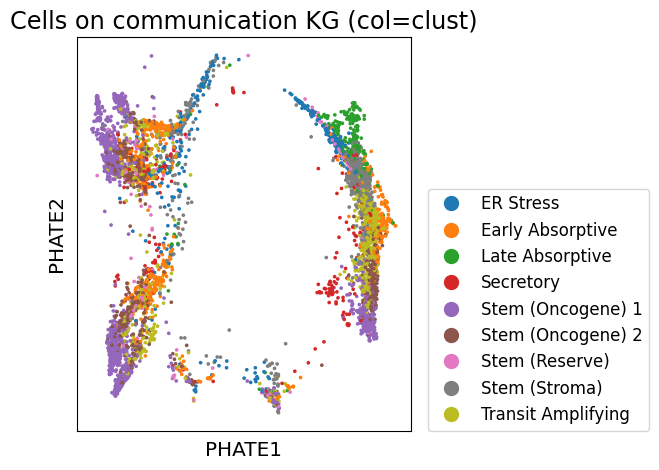

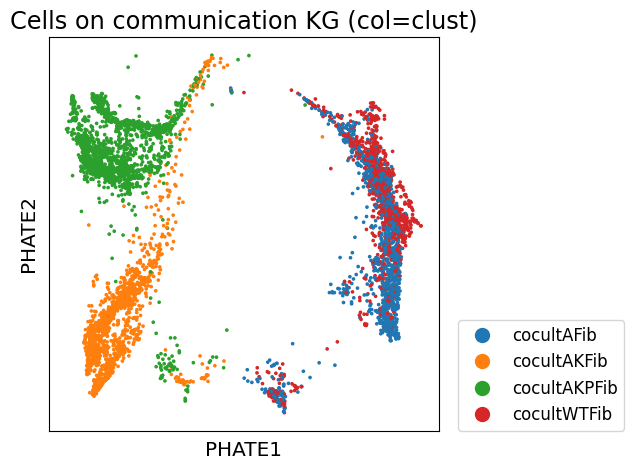

In [18]:
#Compute standard cell phate
phate_op = phate.PHATE() 
data_phate = phate_op.fit_transform(dRnaSeq) 
print(data_phate.shape)
dCellEmbeddings = pd.DataFrame(data=data_phate, index = dRnaSeq.index, columns=["PHATE1","PHATE2"])
del phate_op,data_phate
scprep.plot.scatter2d(
    dCellEmbeddings, c=dSEQmd["finalPOPS"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))
    
scprep.plot.scatter2d(
    dCellEmbeddings, c=dSEQmd["orig.ident"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

## Load KG data

In [18]:
dKGnn = pd.read_csv(f"{data_dir}/dKGnn.csv.tar.gz", header=None)
dKGnn

0        1        2
0                CXCL1       LR    CXCR2
1                CXCL2       LR    CXCR2
2                CXCL3       LR    CXCR2
3                CXCL5       LR    CXCR2
4                 PPBP       LR    CXCR2
...                ...      ...      ...
5444497  R-HSA-6798695  pathway  SIGLEC5
5444498  R-HSA-1181150  pathway  TDGF1P3
5444499  R-HSA-1433617  pathway  TDGF1P3
5444500  R-HSA-3295583  pathway    TRPM5
5444501  R-HSA-9717207  pathway    TRPM5

[5444502 rows x 3 columns]

In [19]:
modelKGE = "KGnn_50_unstratified_stopped_transe"

try:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
except RuntimeError:
    trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl",
    map_location=torch.device("cpu"))

#Construct nodes dataframe: detach() for now is meaningless as compute is CPU
entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
import json
with open(f"{data_dir}/dKGnn_entityIDS.json") as infile:
    entityIDS = json.load(infile)
dKGEnn_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values()).drop(index=["nan"])
dKGEnn_50

0         1         2         3         4         5   \
A1BG     -0.114693 -0.062056 -0.142618 -0.018786  0.079787  0.151638   
A1BG-AS1  0.124340 -0.244321  0.261028  0.177759  0.052111 -0.206777   
A1CF      0.012249  0.097411  0.089748 -0.107028  0.042079 -0.015802   
A2M      -0.076020  0.167864 -0.133910 -0.082698  0.086467 -0.096204   
A2M-AS1  -0.124042 -0.071744  0.190024  0.210376 -0.199619 -0.146263   
...            ...       ...       ...       ...       ...       ...   
ZYG11A    0.157768  0.169630  0.128678 -0.037648  0.034921  0.087765   
ZYG11B    0.154281  0.013954 -0.161645 -0.170701  0.077110  0.007194   
ZYX       0.168261  0.047865 -0.021720 -0.076904 -0.110663  0.096434   
ZZEF1    -0.587509  0.074710 -0.146124  0.098394 -0.006699  0.052911   
ZZZ3      0.082273 -0.122881 -0.079879 -0.102180  0.182568 -0.098044   

                6         7         8         9   ...        40        41  \
A1BG      0.154332 -0.166625 -0.164315  0.150550  ...  0.110171  0.162007   
A1BG-AS1 -0.068553  0.004152 -0.151796  0.048616  ...  0.026584 -0.064389   
A1CF     -0.015080 -0.035531 -0.108423  0.396735  ...  0.109560 -0.146671   
A2M      -0.068033 -0.012295 -0.197465 -0.067780  ...  0.217745  0.121485   
A2M-AS1  -0.201290 -0.032545 -0.092695  0.039749  ... -0.011503  0.263200   
...            ...       ...       ...       ...  ...       ...       ...   
ZYG11A   -0.117535 -0.170905  0.005733  0.032774  ...  0.107611  0.173982   
ZYG11B    0.163640  0.013357  0.084101 -0.117073  ...  0.051953 -0.137357   
ZYX       0.134658 -0.113244  0.069367  0.069998  ...  0.089988 -0.037320   
ZZEF1    -0.004144 -0.310832  0.171271  0.067289  ... -0.024145  0.191872   
ZZZ3      0.037568  0.169248  0.135375  0.008222  ... -0.317155  0.172255   

                42        43        44        45        46        47  \
A1BG      0.136376  0.098658  0.172536  0.010266 -0.002167  0.260938   
A1BG-AS1  0.186161  0.029930  0.043194 -0.230858  0.020652 -0.079490   
A1CF      0.138407  0.118278 -0.090030 -0.198067 -0.064056  0.112160   
A2M      -0.044373  0.006619  0.188977 -0.075680 -0.122628  0.149013   
A2M-AS1  -0.154127  0.032356 -0.221216 -0.127091 -0.050592 -0.162741   
...            ...       ...       ...       ...       ...       ...   
ZYG11A    0.080564  0.081189 -0.287715 -0.076782 -0.078907 -0.008748   
ZYG11B   -0.201208  0.120000 -0.147011  0.176326 -0.140640  0.019583   
ZYX      -0.318342  0.089743  0.215972  0.183160 -0.249219  0.011088   
ZZEF1     0.026109  0.103047  0.075540  0.109647  0.108737 -0.114406   
ZZZ3     -0.062920 -0.214967 -0.019557  0.112612  0.041938 -0.038473   

                48        49  
A1BG     -0.156283  0.223170  
A1BG-AS1 -0.100852 -0.110040  
A1CF     -0.157560  0.070585  
A2M      -0.203135  0.045033  
A2M-AS1   0.066823  0.046689  
...            ...       ...  
ZYG11A   -0.215508 -0.271883  
ZYG11B   -0.134760 -0.269244  
ZYX       0.176135 -0.244414  
ZZEF1    -0.031095 -0.060478  
ZZZ3      0.204341  0.047962  

[27619 rows x 50 columns]

## Match genes in KG and scRNA-seq

In [20]:
dGenesSeq = list(dRnaSeq.columns)

#We still filter the KG, but can we just not filter it and then nan/0 inpute/inflate the count matrix instead?
dKGnn_filt = dKGnn.loc[dKGnn[0].isin(dGenesSeq) & dKGnn[2].isin(dGenesSeq)]
print(dKGnn.shape,dKGnn_filt.shape)

dKGEnn_50filt = dKGEnn_50.loc[dKGEnn_50.index.isin(dGenesSeq)]
print(dKGEnn_50.shape,dKGEnn_50filt.shape)

(5444502, 3) (3552585, 3)
(27619, 50) (12707, 50)


In [21]:
dRnaSeq_filt = dRnaSeq.loc[:,dRnaSeq.columns.isin(dKGEnn_50filt.index)]
print(len(dRnaSeq_filt.columns))
print(dRnaSeq_filt.columns.nunique())

12707
12707


In [22]:
del dKGnn,dKGEnn_50,dRnaSeq,dGenesSeq

### Explore filtered KGnn

In [23]:
G = networkx.from_pandas_edgelist(dKGnn_filt, source=0,target=2,edge_attr=1)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
    networkx.number_of_isolates(G))
print("The graph is connected:",
    networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/var/folders/9p/ypn2045x1cxbq9ptcfk4_k7m0000gn/T/ipykernel_77505/440223923.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 12596 nodes and 2704280 edges, with a density of 0.034091870346812304
We have this many isolates:  0
The graph is connected: True


No need to work with any components.NOte however that the number of entities 
does not match the number of nodes in the networkx object.

In [24]:
dKGnn_filt = dKGnn_filt.loc[dKGnn_filt[0].isin(G.nodes()) & dKGnn_filt[2].isin(G.nodes())]
dKGEnn_50filt = dKGEnn_50filt.loc[dKGEnn_50filt.index.isin(G.nodes())]
dRnaSeq_filt = dRnaSeq_filt.loc[:,dRnaSeq_filt.columns.isin(G.nodes())]
print(dKGnn_filt.shape, dKGEnn_50filt.shape, dRnaSeq_filt.shape)

(3552585, 3) (12596, 50) (5534, 12596)


# Process scRNA data

### Normalise and denoise gene expression data

Use MAGIC with all genes to denoise, smooth and inpute missing values.
Then subset to genes present in KG.
Then normalise so that the gene expression distributions are equally big for each cell.

We will compute MAGIC with default knn-related params (and not giving it a precomputed graph) and using all genes. However, with the `genes` argument, one should be able to return a processed matrix with only the genes present in the KG (whil still leveraging allthe full suite of genes in the dataset)

In [25]:
#MAGIC
magic_op = magic.MAGIC(
    knn=5, # knn_max set to 3*knn by default
    knn_dist="euclidean",
    decay=1, t=3, n_pca=100, random_state=12,
    n_jobs=-2 #All but one
                        )

In [26]:
dMagicRnaSeq = magic_op.fit_transform(
    X = dRnaSeq_filt
)
del magic_op
dMagicRnaSeq

Calculating MAGIC...
  Running MAGIC on 5534 cells and 12596 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.01 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.53 seconds.
    Calculating affinities...
    Calculated affinities in 0.48 seconds.
  Calculated graph and diffusion operator in 3.22 seconds.
  Running MAGIC with `solver='exact'` on 12596-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 3.80 seconds.
Calculated MAGIC in 7.16 seconds.


A1CF    A4GALT     A4GNT      AAAS      AACS  \
WT__AAACGAAAGGAAAGGT-1   0.186134  0.002249  0.000000  0.008958  0.033802   
WT__AAACGAAAGTTAACGA-1   0.030116  0.005061  0.000000  0.035882  0.102993   
WT__AAAGAACAGCAGCGAT-1   0.000467  0.002426  0.000000  0.068588  0.052154   
WT__AAAGAACTCTACTGAG-1   0.002749  0.000534  0.000000  0.284815  0.156396   
WT__AAAGTCCAGTAACGTA-1   0.002107  0.012592  0.000000  0.060522  0.096161   
...                           ...       ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1  0.000000  0.001691  0.000156  0.034217  0.186318   
AKP__TTTGATCGTACGCTAT-1  0.000000  0.004680  0.000011  0.188628  0.167941   
AKP__TTTGGTTTCTCACCCA-1  0.000000  0.000108  0.002537  0.081090  0.146306   
AKP__TTTGTTGGTCGCATTA-1  0.000000  0.000896  0.000172  0.054075  0.166983   
AKP__TTTGTTGGTGTCTTCC-1  0.000000  0.001732  0.004103  0.202902  0.223358   

                            AADAC     AAGAB      AAK1     AAMDC      AAMP  \
WT__AAACGAAAGGAAAGGT-1   0.005258  0.130476  0.072185  0.438559  0.361623   
WT__AAACGAAAGTTAACGA-1   0.000947  0.082245  0.059965  0.391678  0.527820   
WT__AAAGAACAGCAGCGAT-1   0.000000  0.124394  0.032164  0.190015  0.643095   
WT__AAAGAACTCTACTGAG-1   0.000026  0.070677  0.058720  0.178098  0.572541   
WT__AAAGTCCAGTAACGTA-1   0.000000  0.107292  0.063075  0.297118  0.655571   
...                           ...       ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1  0.000000  0.074965  0.069535  0.397984  0.722410   
AKP__TTTGATCGTACGCTAT-1  0.000000  0.087407  0.066428  0.157206  0.673108   
AKP__TTTGGTTTCTCACCCA-1  0.000000  0.097830  0.058771  0.316975  0.712905   
AKP__TTTGTTGGTCGCATTA-1  0.000000  0.087219  0.067915  0.310221  0.640745   
AKP__TTTGTTGGTGTCTTCC-1  0.000000  0.066221  0.073363  0.252773  0.652397   

                         ...    ZSWIM8    ZSWIM9      ZW10    ZWILCH  \
WT__AAACGAAAGGAAAGGT-1   ...  0.072391  0.000274  0.027250  0.000109   
WT__AAACGAAAGTTAACGA-1   ...  0.063014  0.014705  0.026763  0.004765   
WT__AAAGAACAGCAGCGAT-1   ...  0.156200  0.018035  0.020192  0.000682   
WT__AAAGAACTCTACTGAG-1   ...  0.034792  0.015067  0.082525  0.104879   
WT__AAAGTCCAGTAACGTA-1   ...  0.088243  0.012013  0.026124  0.004422   
...                      ...       ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1  ...  0.085252  0.018479  0.013243  0.004580   
AKP__TTTGATCGTACGCTAT-1  ...  0.032268  0.010888  0.080281  0.134378   
AKP__TTTGGTTTCTCACCCA-1  ...  0.052393  0.004091  0.039235  0.035354   
AKP__TTTGTTGGTCGCATTA-1  ...  0.041973  0.014377  0.034315  0.009178   
AKP__TTTGTTGGTGTCTTCC-1  ...  0.033513  0.006552  0.070328  0.123253   

                            ZWINT      ZXDC    ZYG11B       ZYX     ZZEF1  \
WT__AAACGAAAGGAAAGGT-1   0.265006  0.026200  0.064405  0.173139  0.124903   
WT__AAACGAAAGTTAACGA-1   0.598210  0.029044  0.027738  0.150640  0.088212   
WT__AAAGAACAGCAGCGAT-1   0.549295  0.036267  0.057759  0.376207  0.040369   
WT__AAAGAACTCTACTGAG-1   0.544608  0.021404  0.043684  0.080847  0.047569   
WT__AAAGTCCAGTAACGTA-1   0.641731  0.028461  0.050328  0.261394  0.079842   
...                           ...       ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1  0.353080  0.034303  0.043465  0.117572  0.049769   
AKP__TTTGATCGTACGCTAT-1  0.510592  0.024756  0.030014  0.096752  0.062024   
AKP__TTTGGTTTCTCACCCA-1  0.359450  0.028926  0.044513  0.119833  0.037616   
AKP__TTTGTTGGTCGCATTA-1  0.323362  0.035164  0.050955  0.120378  0.031568   
AKP__TTTGTTGGTGTCTTCC-1  0.452247  0.023683  0.042197  0.085102  0.051337   

                             ZZZ3  
WT__AAACGAAAGGAAAGGT-1   0.061003  
WT__AAACGAAAGTTAACGA-1   0.073471  
WT__AAAGAACAGCAGCGAT-1   0.104990  
WT__AAAGAACTCTACTGAG-1   0.084431  
WT__AAAGTCCAGTAACGTA-1   0.153166  
...                           ...  
AKP__TTTGACTTCCTTCAGC-1  0.139535  
AKP__TTTGATCGTACGCTAT-1  0.128333  
AKP__TTTGGTTTCTCACCCA-1  0.095055  
AKP__TTTGTTGGTCGCATTA-1  0.10

View gene-gene scatter for cycle, fibro and epi genes b4 and after MAGIC

In [27]:
print(mouse2human["Cd44"] in dMagicRnaSeq.columns)
print(mouse2human["Fabp2"] in dMagicRnaSeq.columns)
print(mouse2human["Epcam"] in dMagicRnaSeq.columns)

print(mouse2human["Pdgfra"] in dMagicRnaSeq.columns)
print(mouse2human["Fabp2"] in dMagicRnaSeq.columns)
print(mouse2human["Thy1"] in dMagicRnaSeq.columns)

True
True
True
True
True
True


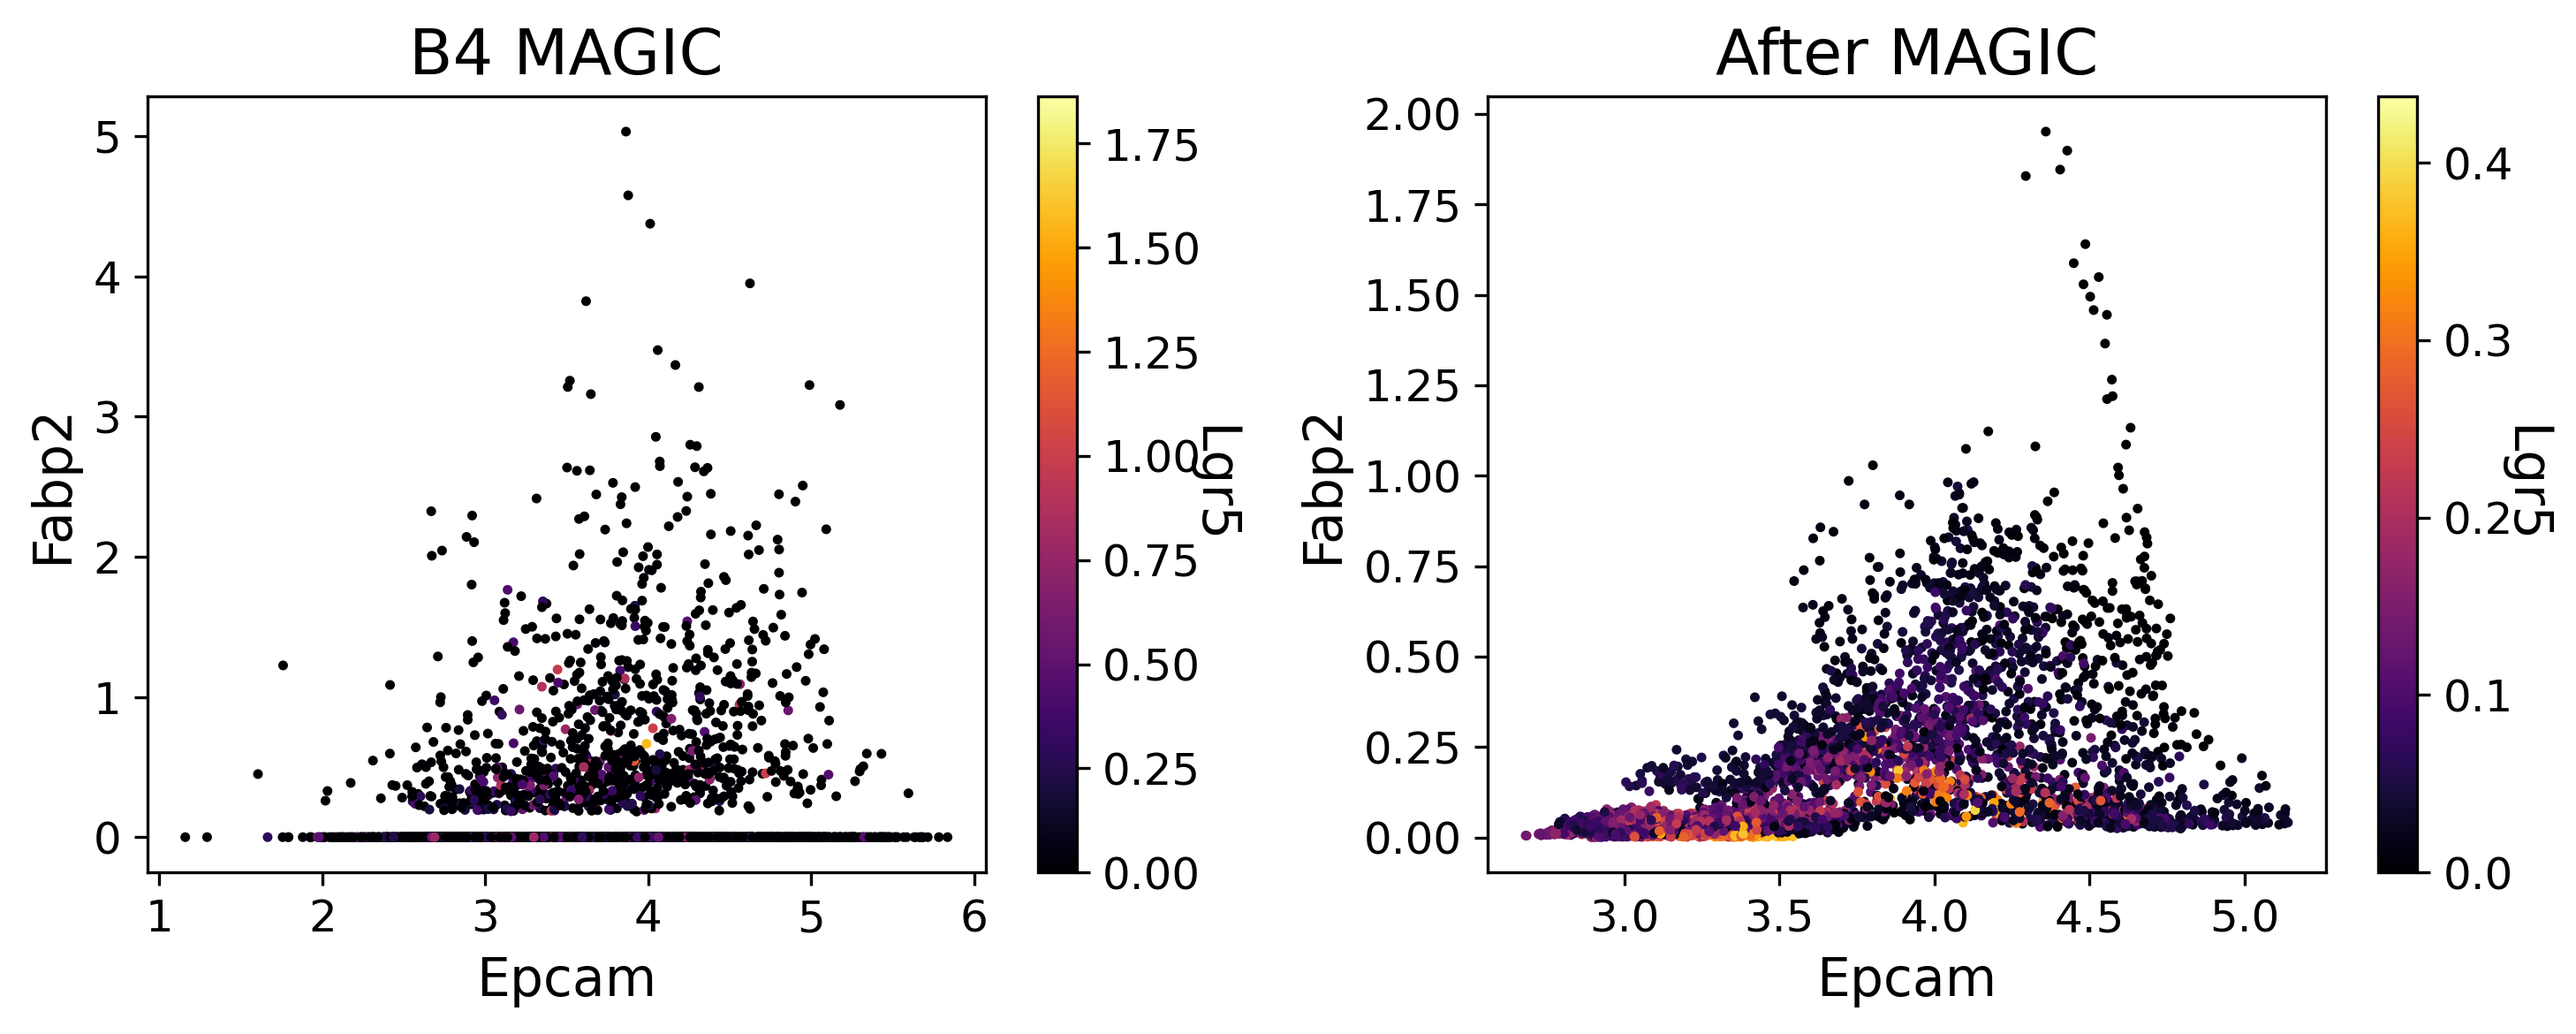

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq_filt[mouse2human["Epcam"]], y=dRnaSeq_filt[mouse2human["Fabp2"]], 
    c=dRnaSeq_filt[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Epcam"]], y=dMagicRnaSeq[mouse2human["Fabp2"]], 
    c=dMagicRnaSeq[mouse2human["Lgr5"]],
    xlabel="Epcam", ylabel="Fabp2", legend_title="Lgr5", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

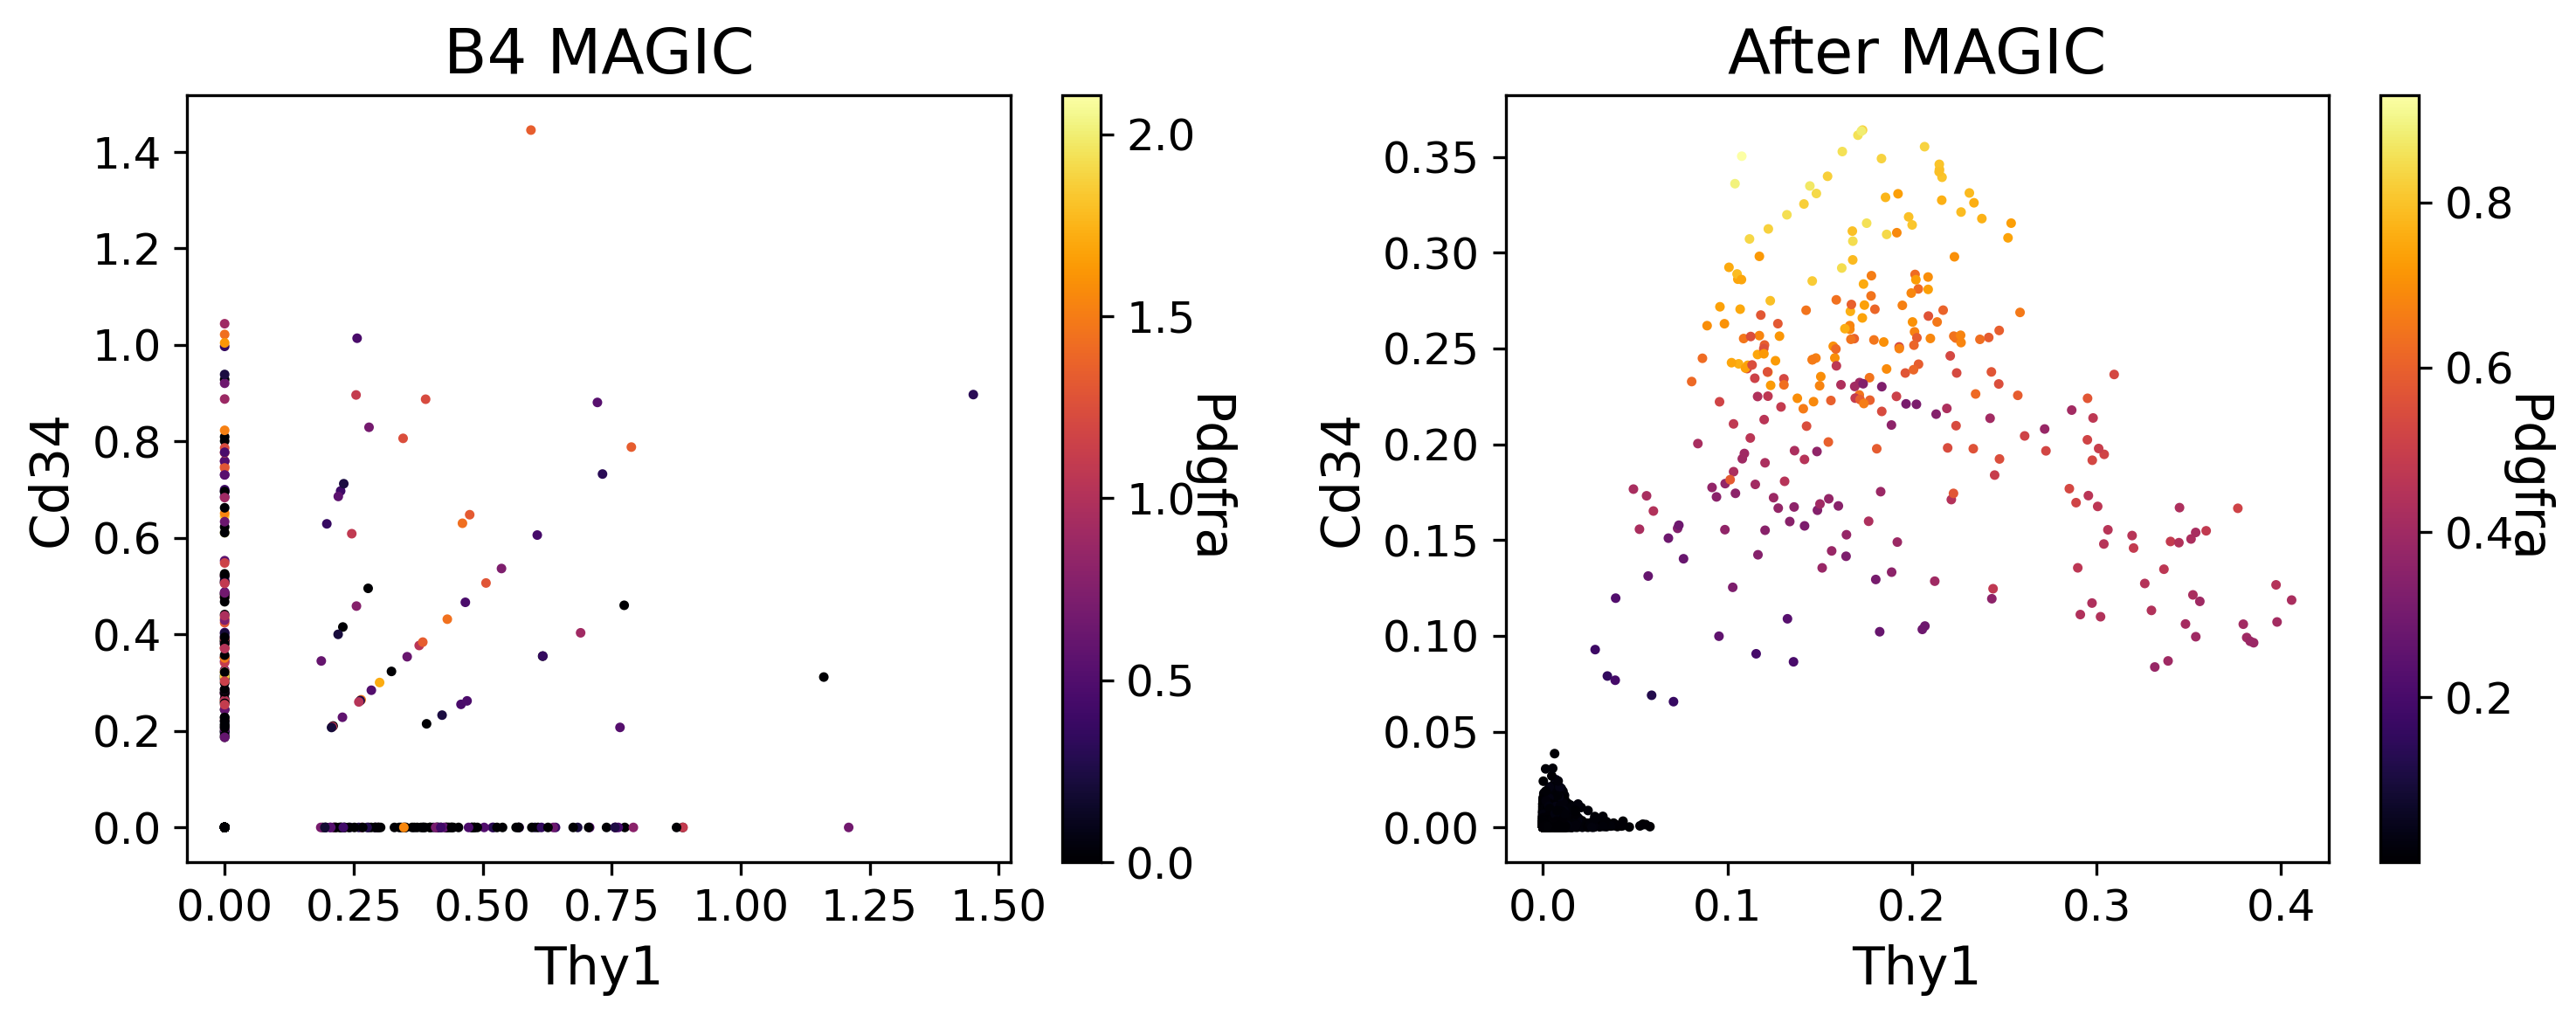

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4), dpi=300)

scprep.plot.scatter(
    x=dRnaSeq_filt[mouse2human["Thy1"]], y=dRnaSeq_filt[mouse2human["Cd34"]], 
    c=dRnaSeq_filt[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax1, title="B4 MAGIC")
scprep.plot.scatter(
    x=dMagicRnaSeq[mouse2human["Thy1"]], y=dMagicRnaSeq[mouse2human["Cd34"]], 
    c=dMagicRnaSeq[mouse2human["Pdgfra"]],
    xlabel="Thy1", ylabel="Cd34", legend_title="Pdgfra", 
    ax=ax2, title="After MAGIC")

plt.tight_layout()
plt.show()

In [30]:
del dRnaSeq_filt

Now, let's create a dataframe where gene expression values have been scalled row-wise (might be useful for the first DEMD approach, for wich we would need the gene expression arrays to summ up to the same value across all cells).

We can apply this scalling by computing the total sum of values for each row and then dividing the expression values for each gene in that cell by that sum.

In [31]:
#Cell-scalled GEX:
dScalRnaSeq = dMagicRnaSeq.div(dMagicRnaSeq.sum(axis=1), axis=0)
del dMagicRnaSeq
dScalRnaSeq

A1CF        A4GALT         A4GNT      AAAS  \
WT__AAACGAAAGGAAAGGT-1   7.572739e-05  9.149898e-07  0.000000e+00  0.000004   
WT__AAACGAAAGTTAACGA-1   1.107508e-05  1.861086e-06  0.000000e+00  0.000013   
WT__AAAGAACAGCAGCGAT-1   1.660131e-07  8.629215e-07  0.000000e+00  0.000024   
WT__AAAGAACTCTACTGAG-1   9.306353e-07  1.806756e-07  0.000000e+00  0.000096   
WT__AAAGTCCAGTAACGTA-1   7.255184e-07  4.335126e-06  0.000000e+00  0.000021   
...                               ...           ...           ...       ...   
AKP__TTTGACTTCCTTCAGC-1  0.000000e+00  5.736200e-07  5.278224e-08  0.000012   
AKP__TTTGATCGTACGCTAT-1  0.000000e+00  1.510515e-06  3.557985e-09  0.000061   
AKP__TTTGGTTTCTCACCCA-1  0.000000e+00  3.561216e-08  8.383554e-07  0.000027   
AKP__TTTGTTGGTCGCATTA-1  0.000000e+00  3.030131e-07  5.807329e-08  0.000018   
AKP__TTTGTTGGTGTCTTCC-1  0.000000e+00  5.601388e-07  1.327228e-06  0.000066   

                             AACS         AADAC     AAGAB      AAK1     AAMDC  \
WT__AAACGAAAGGAAAGGT-1   0.000014  2.139323e-06  0.000053  0.000029  0.000178   
WT__AAACGAAAGTTAACGA-1   0.000038  3.483751e-07  0.000030  0.000022  0.000144   
WT__AAAGAACAGCAGCGAT-1   0.000019  0.000000e+00  0.000044  0.000011  0.000068   
WT__AAAGAACTCTACTGAG-1   0.000053  8.819232e-09  0.000024  0.000020  0.000060   
WT__AAAGTCCAGTAACGTA-1   0.000033  0.000000e+00  0.000037  0.000022  0.000102   
...                           ...           ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1  0.000063  0.000000e+00  0.000025  0.000024  0.000135   
AKP__TTTGATCGTACGCTAT-1  0.000054  0.000000e+00  0.000028  0.000021  0.000051   
AKP__TTTGGTTTCTCACCCA-1  0.000048  0.000000e+00  0.000032  0.000019  0.000105   
AKP__TTTGTTGGTCGCATTA-1  0.000056  0.000000e+00  0.000030  0.000023  0.000105   
AKP__TTTGTTGGTGTCTTCC-1  0.000072  0.000000e+00  0.000021  0.000024  0.000082   

                             AAMP  ...    ZSWIM8        ZSWIM9      ZW10  \
WT__AAACGAAAGGAAAGGT-1   0.000147  ...  0.000029  1.113059e-07  0.000011   
WT__AAACGAAAGTTAACGA-1   0.000194  ...  0.000023  5.407854e-06  0.000010   
WT__AAAGAACAGCAGCGAT-1   0.000229  ...  0.000056  6.413764e-06  0.000007   
WT__AAAGAACTCTACTGAG-1   0.000194  ...  0.000012  5.100778e-06  0.000028   
WT__AAAGTCCAGTAACGTA-1   0.000226  ...  0.000030  4.135607e-06  0.000009   
...                           ...  ...       ...           ...       ...   
AKP__TTTGACTTCCTTCAGC-1  0.000245  ...  0.000029  6.270348e-06  0.000004   
AKP__TTTGATCGTACGCTAT-1  0.000217  ...  0.000010  3.514307e-06  0.000026   
AKP__TTTGGTTTCTCACCCA-1  0.000236  ...  0.000017  1.352151e-06  0.000013   
AKP__TTTGTTGGTCGCATTA-1  0.000217  ...  0.000014  4.863935e-06  0.000012   
AKP__TTTGTTGGTGTCTTCC-1  0.000211  ...  0.000011  2.119430e-06  0.000023   

                               ZWILCH     ZWINT      ZXDC    ZYG11B       ZYX  \
WT__AAACGAAAGGAAAGGT-1   4.428204e-08  0.000108  0.000011  0.000026  0.000070   
WT__AAACGAAAGTTAACGA-1   1.752174e-06  0.000220  0.000011  0.000010  0.000055   
WT__AAAGAACAGCAGCGAT-1   2.426260e-07  0.000195  0.000013  0.000021  0.000134   
WT__AAAGAACTCTACTGAG-1   3.550686e-05  0.000184  0.000007  0.000015  0.000027   
WT__AAAGTCCAGTAACGTA-1   1.522438e-06  0.000221  0.000010  0.000017  0.000090   
...                               ...       ...       ...       ...       ...   
AKP__TTTGACTTCCTTCAGC-1  1.554123e-06  0.000120  0.000012  0.000015  0.000040   
AKP__TTTGATCGTACGCTAT-1  4.337170e-05  0.000165  0.000008  0.000010  0.000031   
AKP__TTTGGTTTCTCACCCA-1  1.168414e-05  0.000119  0.000010  0.000015  0.000040   
AKP__TTTGTTGGTCGCATTA-1  3.105102e-06  0.000109  0.000012  0.000017  0.000041   
AKP__TTTGTTGGTGTCTTCC-1  3.986743e-05  0.000146  0.000008  0.000014  0.000028   

                            ZZEF1      ZZZ3  
WT__AAACGAAAGGAAAGGT-1   0.000051  0.000025  
WT__AAACGAAAGTTAACGA-1   0.000032  0.000027  
WT__AAAGAACAGCAGCGAT-1   0.000014  0.000037  
WT__AAAGAACTCTACTGAG-1   0.000016  0.0000

# Wavelet dictionaries

## Wavelets on KG

From the gene-gene KG get a wavelet dictionary at multiscales based on gene expression.
The resulting gene**X**wavelet matrix can be multiplied against a gene**X**cell matrix (from scRNA-seq data) in order to project the cells onto the wavelets.

This approach should be able to incorporate proteomic data from CyTOF too, as PTMs will also be nodes on the graph and we will work with a node**X**wavelet matrix.

### Compute wavelets

First convert the current networkx graph (for now the 1st component) into a pygsp Graph.
That object can then be used by the wavelet code.

1- Using [networkx](https://networkx.org/documentation/stable/install.html) package.

    - From the integrated database, we've made a pandas dataframe that has only the 
    source and target columns and then use that to make a NetworkX Graph object 
    with `from_pandas_edgelist`

In [32]:
print(pygsp.__version__)

pyG = pygsp.graphs.Graph(W=networkx.to_numpy_array(G))
pyG

0.5.1


2022-10-06 18:16:53,254:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [33]:
wavloc = Localizer(pyG) #Takes only pygsp graphs
wavloc.CalculateWavelets(J=4) #J is the scale param. Confirmed
wavloc.FlattenAndNormalize()
wavloc.FlatWaves.shape

Calculating Wavelets Using J = 4


100%|██████████| 2/2 [00:22<00:00, 11.43s/it]


Flattening and Normalizing Wavelets


100%|██████████| 4/4 [00:16<00:00,  4.20s/it]


(12596, 50384)

Resulting object, accessed via .FlatWaves, is a gene**X**wavelet matrix

In [34]:
wavloc.FlatWaves

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85818201e-04, -9.90728921e-05, -1.00473308e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.42820292e-03,  7.08064791e-04,  4.16422635e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
        -1.53795331e-04, -1.31520148e-04,  1.67962532e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.73820664e-01, -3.32585262e-06, -2.18315871e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.78941627e-06,  4.22842560e-01, -1.68411340e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.94721608e-07, -9.14907620e-07,  2.59032848e-01]])

### Project cells on geneXwavelet matrix

To project the cells on the gene**X**wavelet matrix we will multiply a cell**X**gene matrix by the gene**X**wavelet matrix, resulting in a cell**X**wavelet matrix

In [35]:
#Reorder GEX data based on adjacency matrix
dScalRnaSeq = dScalRnaSeq.reindex(
                columns=list(G.nodes())
                )
dScalRnaSeq

PPBP         CXCR2         CXCL6      CCL2  \
WT__AAACGAAAGGAAAGGT-1   0.000000e+00  0.000000e+00  3.224810e-06  0.000066   
WT__AAACGAAAGTTAACGA-1   1.885658e-07  0.000000e+00  3.046070e-05  0.000049   
WT__AAAGAACAGCAGCGAT-1   4.176401e-06  0.000000e+00  2.700388e-05  0.000046   
WT__AAAGAACTCTACTGAG-1   4.927501e-08  0.000000e+00  9.695579e-06  0.000032   
WT__AAAGTCCAGTAACGTA-1   4.825485e-07  0.000000e+00  3.731287e-05  0.000047   
...                               ...           ...           ...       ...   
AKP__TTTGACTTCCTTCAGC-1  1.450752e-08  1.323512e-07  1.130237e-07  0.000036   
AKP__TTTGATCGTACGCTAT-1  9.472527e-07  0.000000e+00  4.158582e-07  0.000027   
AKP__TTTGGTTTCTCACCCA-1  6.702115e-09  4.453062e-07  3.008690e-07  0.000028   
AKP__TTTGTTGGTCGCATTA-1  2.336324e-07  1.324222e-07  5.119476e-07  0.000030   
AKP__TTTGTTGGTGTCTTCC-1  0.000000e+00  3.732756e-07  1.074923e-07  0.000029   

                                 CCR2      CCL7          CCR1         CCL23  \
WT__AAACGAAAGGAAAGGT-1   0.000000e+00  0.000057  0.000000e+00  1.641748e-07   
WT__AAACGAAAGTTAACGA-1   0.000000e+00  0.000059  0.000000e+00  2.653165e-06   
WT__AAAGAACAGCAGCGAT-1   0.000000e+00  0.000044  0.000000e+00  2.127453e-06   
WT__AAAGAACTCTACTGAG-1   0.000000e+00  0.000033  0.000000e+00  1.059682e-06   
WT__AAAGTCCAGTAACGTA-1   0.000000e+00  0.000045  0.000000e+00  2.728067e-06   
...                               ...       ...           ...           ...   
AKP__TTTGACTTCCTTCAGC-1  0.000000e+00  0.000022  0.000000e+00  6.527521e-06   
AKP__TTTGATCGTACGCTAT-1  1.024461e-08  0.000013  0.000000e+00  1.259493e-07   
AKP__TTTGGTTTCTCACCCA-1  6.443123e-09  0.000014  1.070112e-08  7.524574e-06   
AKP__TTTGTTGGTCGCATTA-1  9.345886e-10  0.000023  0.000000e+00  2.882867e-06   
AKP__TTTGTTGGTGTCTTCC-1  6.193721e-09  0.000011  0.000000e+00  7.340801e-06   

                                CCL28         CCR10  ...      CATSPERZ  \
WT__AAACGAAAGGAAAGGT-1   4.164762e-06  4.034878e-08  ...  0.000000e+00   
WT__AAACGAAAGTTAACGA-1   4.728492e-07  5.568461e-09  ...  0.000000e+00   
WT__AAAGAACAGCAGCGAT-1   3.647334e-09  2.382833e-07  ...  0.000000e+00   
WT__AAAGAACTCTACTGAG-1   7.170818e-09  2.814613e-09  ...  0.000000e+00   
WT__AAAGTCCAGTAACGTA-1   2.220577e-08  3.953233e-09  ...  0.000000e+00   
...                               ...           ...  ...           ...   
AKP__TTTGACTTCCTTCAGC-1  1.092089e-06  3.412468e-07  ...  9.621133e-07   
AKP__TTTGATCGTACGCTAT-1  1.015279e-07  2.941335e-08  ...  1.835295e-08   
AKP__TTTGGTTTCTCACCCA-1  5.418963e-06  9.151898e-08  ...  8.829957e-07   
AKP__TTTGTTGGTCGCATTA-1  8.041406e-07  4.948362e-07  ...  1.538851e-06   
AKP__TTTGTTGGTGTCTTCC-1  7.341224e-08  3.166339e-09  ...  5.098681e-07   

                                SAXO2        TRBV30      TRAV12-2   CEBPZOS  \
WT__AAACGAAAGGAAAGGT-1   8.639699e-07  1.579380e-08  2.506699e-06  0.000254   
WT__AAACGAAAGTTAACGA-1   7.989563e-06  1.287334e-06  1.313906e-06  0.000354   
WT__AAAGAACAGCAGCGAT-1   2.689757e-06  2.542243e-07  1.389372e-08  0.000297   
WT__AAAGAACTCTACTGAG-1   3.487664e-06  0.000000e+00  1.520787e-07  0.000296   
WT__AAAGTCCAGTAACGTA-1   5.937250e-06  1.816470e-06  1.005670e-07  0.000307   
...                               ...           ...           ...       ...   
AKP__TTTGACTTCCTTCAGC-1  7.494687e-06  0.000000e+00  0.000000e+00  0.000275   
AKP__TTTGATCGTACGCTAT-1  1.543864e-06  0.000000e+00  0.000000e+00  0.000275   
AKP__TTTGGTTTCTCACCCA-1  8.864540e-06  0.000000e+00  0.000000e+00  0.000292   
AKP__TTTGTTGGTCGCATTA-1  3.975758e-06  0.000000e+00  0.000000e+00  0.000278   
AKP__TTTGTTGGTGTCTTCC-1  4.973226e-06  0.000000e+00  0.000000e+00  0.000267   

                              ANKRD62    INAFM2     AK4P3    SMIM29  \
WT__AAACGAAAGGAAAGGT-1   4.231265e-08  0.000013  0.000015  0.000162   
WT__AAACGAAAGTTAACGA-1   2.949848e-06  0.000011  0.000028  0.000155   
WT__AAAGAACAGCAGCGAT-1   8.893400e-07  0.000017  0.000027  0.000114   
WT__AAAGAACTC

In [36]:
#Multiply 2 matrices using the dot product
cell_projection = np.dot(dScalRnaSeq, wavloc.FlatWaves)
cell_projection.shape #Shape should be 3.7k rows by 50k columns

(5534, 50384)

This is essentially a cell-cell graph based on their differences on the comns KG. 
We can thus use this to get some phate embeddings or any other downstream steps.

In [37]:
#Save to file as compressed npy object
np.savez_compressed(f"{data_dir}/cell_projection_nnKGwav_GENepi.npz", cell_projection)

In [38]:
cell_projection = np.load(f"{data_dir}/cell_projection_nnKGwav_GENepi.npz")["arr_0"]#Dict-like struct.Default arr_N keys
cell_projection.shape 

(5534, 50384)

## Rmv objects from mem

In [39]:
del wavloc,pyG,dKGnn_filt,dKGEnn_50filt

## Downstream 

#### Embed projections on PHATE

In [40]:
phate_op = phate.PHATE() 
data_phate = phate_op.fit_transform(cell_projection) 

Calculating PHATE...
  Running PHATE on 5534 observations and 50384 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.20 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.90 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 8.12 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.37 seconds.
  Calculated landmark operator in 5.24 seconds.
  Calculating optimal t...
    Automatically selected t = 43
  Calculated optimal t in 1.55 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.39 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.47 seconds.
Calculated PHATE in 18.77 seconds.


In [41]:
print(data_phate.shape)
dCellEmbeddings = pd.DataFrame(data=data_phate, index = dScalRnaSeq.index, columns=["PHATE1","PHATE2"])
del phate_op,data_phate
dCellEmbeddings

(5534, 2)


PHATE1    PHATE2
WT__AAACGAAAGGAAAGGT-1   0.013899 -0.000728
WT__AAACGAAAGTTAACGA-1   0.019548 -0.007243
WT__AAAGAACAGCAGCGAT-1   0.017688 -0.006112
WT__AAAGAACTCTACTGAG-1   0.020627  0.007873
WT__AAAGTCCAGTAACGTA-1   0.019888 -0.004710
...                           ...       ...
AKP__TTTGACTTCCTTCAGC-1 -0.017513 -0.005012
AKP__TTTGATCGTACGCTAT-1 -0.012112 -0.014324
AKP__TTTGGTTTCTCACCCA-1 -0.018690 -0.007322
AKP__TTTGTTGGTCGCATTA-1 -0.017072 -0.005351
AKP__TTTGTTGGTGTCTTCC-1 -0.017153 -0.010217

[5534 rows x 2 columns]

/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ferran/miniconda3/envs/collabLite/lib/python3.9/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: title={'center': 'Cells on communication KG (col=clust)'}, xlabel='PHATE1', ylabel='PHATE2'>

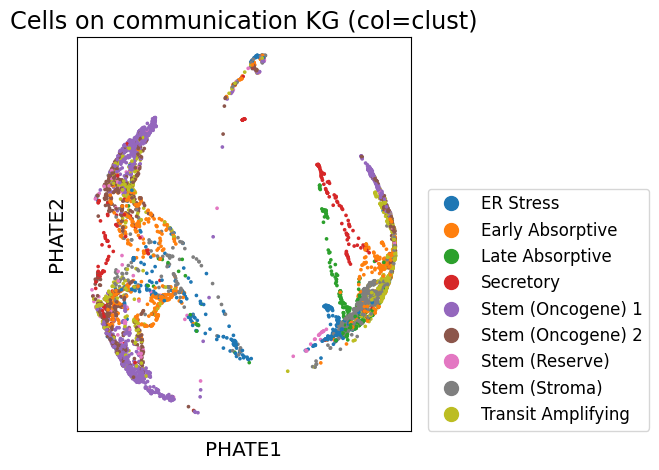

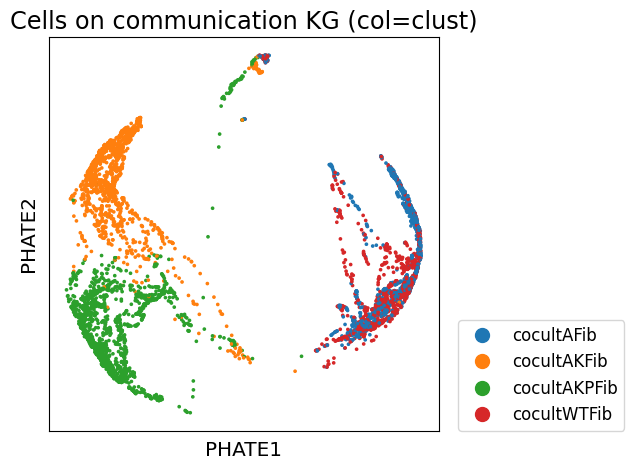

In [42]:
scprep.plot.scatter2d(
    dCellEmbeddings, c=dSEQmd["finalPOPS"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))
    
scprep.plot.scatter2d(
    dCellEmbeddings, c=dSEQmd["orig.ident"],
    title="Cells on communication KG (col=clust)", ticks=None,
    legend_loc=(1.05, 0))

##### Results

Using the wavelet approach we get a very similar PHATE space as that from the DEMD approach. 

Before continuing further we should explore some kind of tunning of the KG, perhaps aiminig to *sparsify* it?